# Peak Fit Method Comparison

This notebook reads Raman spectra data, normalizes the spectra, fits the 2D peak using Pseudo-Voigt and Lorentzian models, and plots the results.

## 1. Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import LorentzianModel, PseudoVoigtModel

- **`pandas`**: For handling and manipulating the dataset.
- **`numpy`**: For numerical operations.
- **`matplotlib`**: For plotting the results.
- **`lmfit.models`**: For fitting models to the spectra.

## 2. Define Peak Ranges

In [2]:
GRAPHENEPEAKS = [
    {"prefix": "D", "range": {"min": 1290.0, "max": 1420.0}},
    {"prefix": "G", "range": {"min": 1480.0, "max": 1700.0}},
    {"prefix": "twoD", "range": {"min": 2580.0, "max": 2790.0}},
]


- **`g_peak`**: Defines the range for the G peak.
- **`twoD_peak`**: Defines the range for the 2D peak.

## 3. Load and Parse the Spectra Data


In [3]:
# Define the relative file path from the notebook's location
file_path = "./Data/RawData/1615_rtAC_hotAc.txt"

# Check if the file exists
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")

with open(file_path, "r") as file:
    raman_shift_values = [float(value) for value in file.readline().split()]

df = pd.read_csv(file_path, sep="\s+", header=None, skiprows=1)
df.columns = ["mapX", "mapY"] + [f"{raman_shift:.0f}" for raman_shift in raman_shift_values]

The file './Data/RawData/1615_rtAC_hotAc.txt' exists.


- The first line of the file contains the **Raman shift values**, which are read into a list **`raman_shift_values`**.
- The rest of the file is read into a **DataFrame `df`**, skipping the first line.
- The columns of the DataFrame are set to **"mapX"**, **"mapY"**, and the **Raman shift values**.

## 4. Normalize the Spectra

In [4]:
def normalize_spectrum(spectrum, raman_shift_values, peak_range):
    mask = (raman_shift_values >= peak_range['min']) & (raman_shift_values <= peak_range['max'])
    g_peak_intensity = np.max(spectrum[mask])
    return spectrum / g_peak_intensity

normalized_spectra = df.iloc[:, 2:].apply(lambda row: normalize_spectrum(row.to_numpy(), np.array(raman_shift_values), GRAPHENEPEAKS[1]['range']), axis=1)
normalized_spectra = pd.DataFrame(normalized_spectra.tolist(), columns=df.columns[2:])

- **`normalize_spectrum`** function normalizes a given spectrum by dividing it by the maximum intensity in the specified **G peak range**.
- The spectra are normalized by applying this function to each row in the DataFrame **`df`**, ignoring the first two columns (**`mapX`** and **`mapY`**).

## 5. Initialize Models for Fitting

In [5]:
pseudo_voigt_model = PseudoVoigtModel(prefix=GRAPHENEPEAKS[2]['prefix'])
lorentz_model = LorentzianModel(prefix=GRAPHENEPEAKS[2]['prefix'])

- Initialize **`PseudoVoigtModel`** and **`LorentzianModel`** for fitting the 2D peak.

## 6. Function to Fit the 2D Peak

In [6]:
def fit_twoD_peak(data, x, peak_range, model):
    mask = (x >= peak_range['min']) & (x <= peak_range['max'])
    x_range = x[mask]
    y_range = data[mask]  # Directly use numpy array indexing
    params = model.guess(y_range, x=x_range)
    result = model.fit(y_range, params, x=x_range)
    return result

- **`fit_twoD_peak`** function fits the data within the specified **2D peak range** using the given model (**Pseudo-Voigt** or **Lorentzian**).
- It creates a mask to select the data within the range, guesses initial parameters, and fits the model.

## 7. Fit Each Spectrum Individually

In [7]:
fitted_spectra_pseudo_voigt = pd.DataFrame(columns=df.columns[2:], index=df.index)
fitted_spectra_lorentz = pd.DataFrame(columns=df.columns[2:], index=df.index)

for index, row in normalized_spectra.iterrows():
    spectrum_data = row.to_numpy()  # Convert to numpy array for safe handling
    peak_result_pseudo_voigt = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[2]['range'], pseudo_voigt_model)
    peak_result_lorentz = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[2]['range'], lorentz_model)
    fitted_spectra_pseudo_voigt.loc[index, [f"{val:.0f}" for val in peak_result_pseudo_voigt.userkws['x']]] = peak_result_pseudo_voigt.best_fit
    fitted_spectra_lorentz.loc[index, [f"{val:.0f}" for val in peak_result_lorentz.userkws['x']]] = peak_result_lorentz.best_fit

- Iterate through each row (spectrum) in **`normalized_spectra`**.
- Convert each row to a numpy array for safe handling.
- Fit the spectrum using both **Pseudo-Voigt** and **Lorentzian** models.
- Store the best fit results in **`fitted_spectra_pseudo_voigt`** and **`fitted_spectra_lorentz`** DataFrames.

## 8. Calculate the Average Spectra

In [8]:
mask = (np.array(raman_shift_values) >= GRAPHENEPEAKS[2]['range']['min']) & (np.array(raman_shift_values) <= GRAPHENEPEAKS[2]['range']['max'])
avg_fitted_spectrum_pseudo_voigt = fitted_spectra_pseudo_voigt.mean(axis=0)
avg_fitted_spectrum_lorentz = fitted_spectra_lorentz.mean(axis=0)
avg_raw_spectrum = normalized_spectra.mean(axis=0)

- Create a mask for the **2D peak range**.
- Calculate the average of the fitted spectra (**`avg_fitted_spectrum_pseudo_voigt`** and **`avg_fitted_spectrum_lorentz`**) and the average raw spectrum (**`avg_raw_spectrum`**) within this range.

## 9. Plot the Results

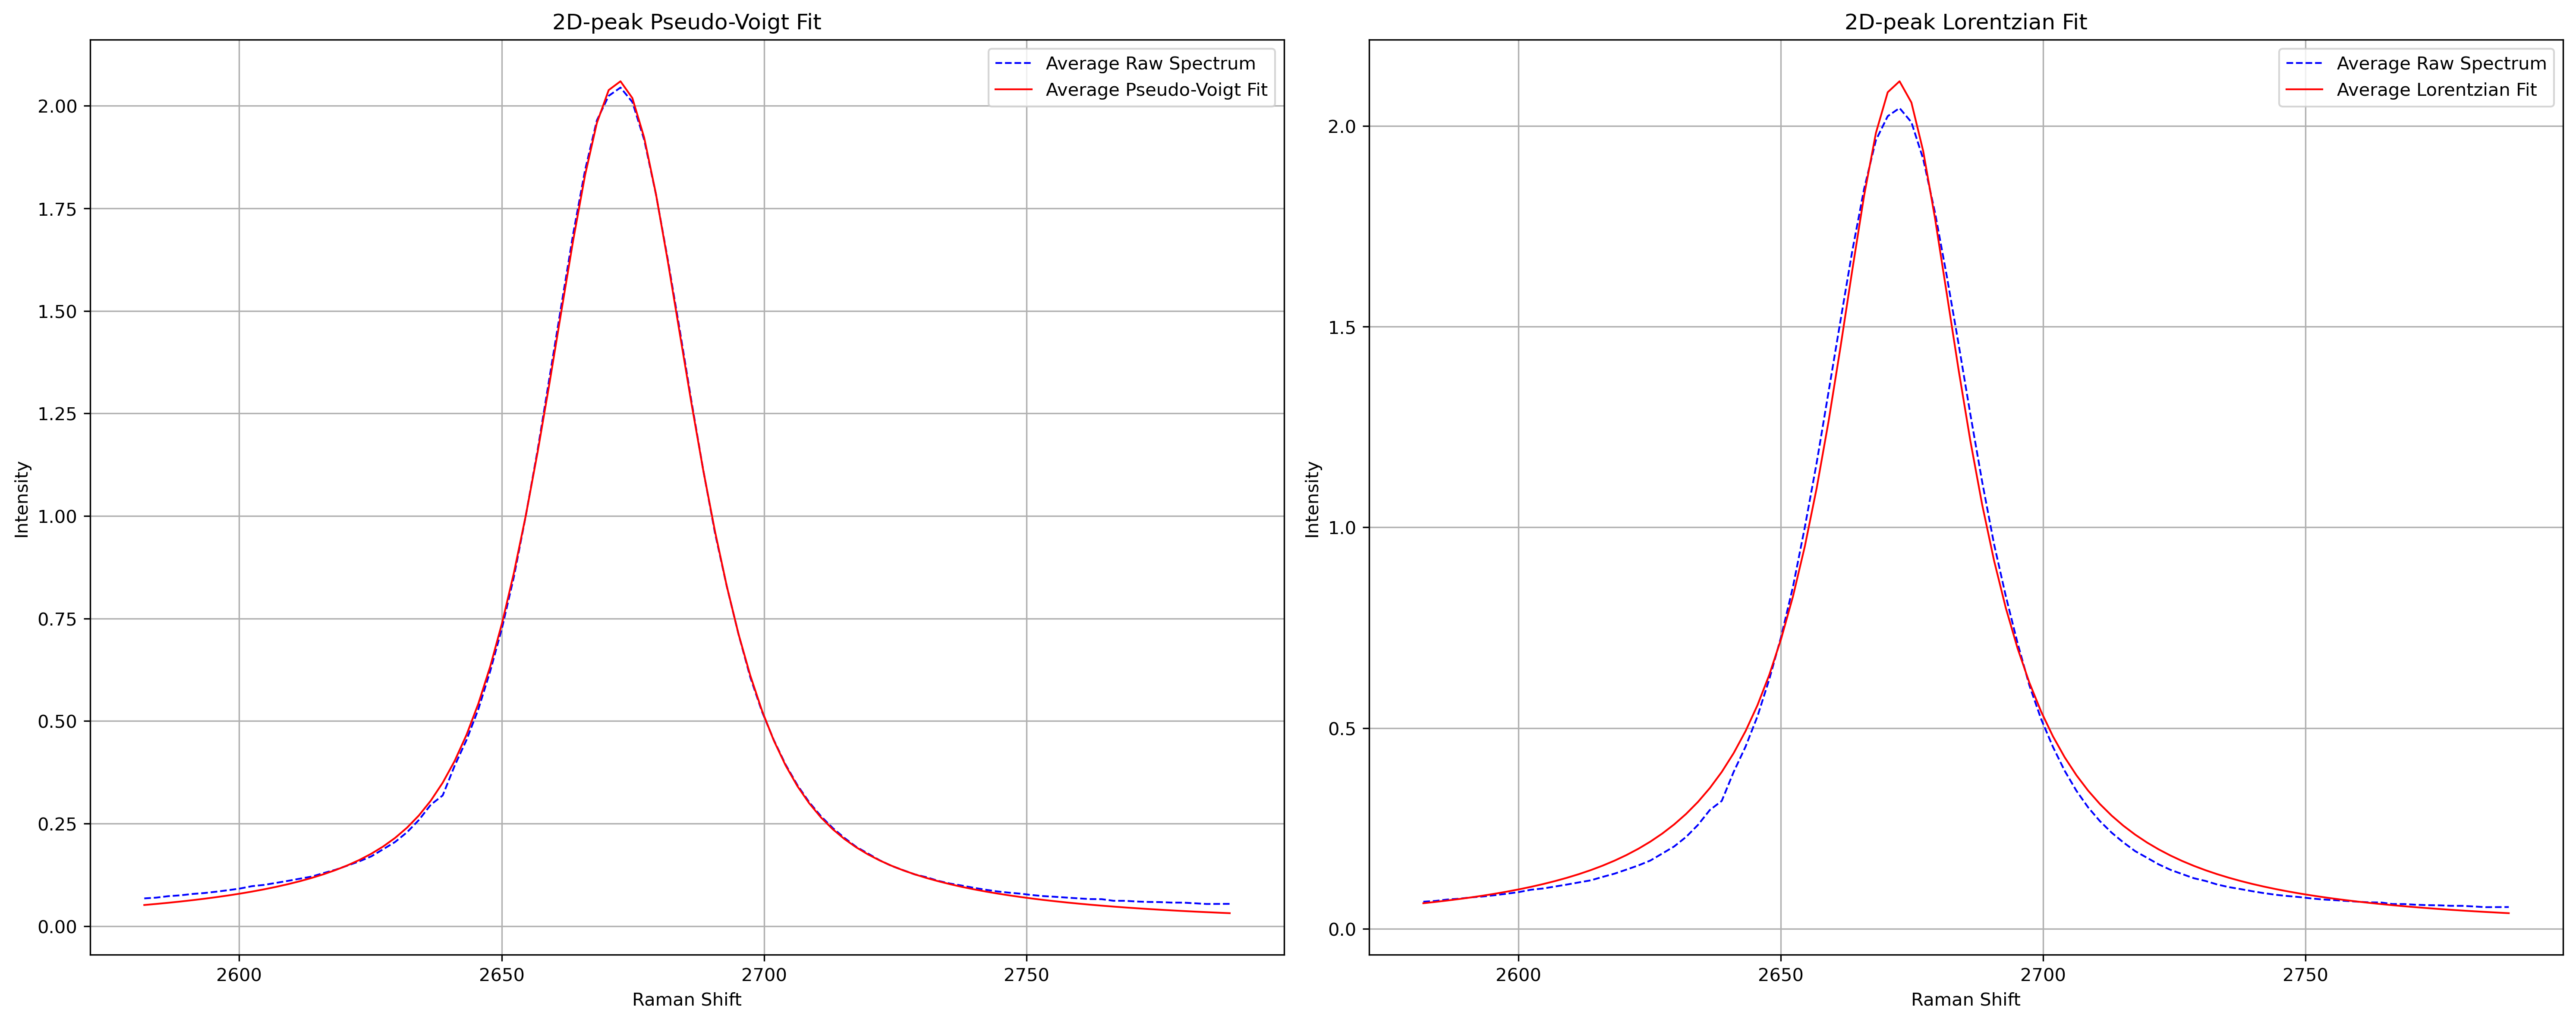

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8), dpi=300)

# Plot for the Pseudo-Voigt fit
axs[0].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1, color='blue')
axs[0].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_pseudo_voigt[mask], label='Average Pseudo-Voigt Fit', linestyle='-', linewidth=1, color='red')
axs[0].set_title('2D-peak Pseudo-Voigt Fit')
axs[0].set_xlabel('Raman Shift')
axs[0].set_ylabel('Intensity')
axs[0].legend()
axs[0].grid(True)

# Plot for the Lorentzian fit
axs[1].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1, color='blue')
axs[1].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_lorentz[mask], label='Average Lorentzian Fit', linestyle='-', linewidth=1, color='red')
axs[1].set_title('2D-peak Lorentzian Fit')
axs[1].set_xlabel('Raman Shift')
axs[1].set_ylabel('Intensity')
axs[1].legend()
axs[1].grid(True)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the combined plot
plt.show()

- Create subplots for plotting the results.
- Plot the average raw spectrum and average fitted spectra for both **Pseudo-Voigt** and **Lorentzian** fits.
- Configure titles, labels, legends, and grid for each plot.
- Adjust the layout to prevent label clipping and display the plots.

### Summary


The code reads **Raman spectra data** from a file, normalizes the spectra with respect to the **G-peak intensity**, fits the 2D peak using **Pseudo-Voigt** and **Lorentzian** models, and plots the average raw and fitted spectra for the 2D peak. It specifies the ranges for the **G** and **2D peaks** and uses these ranges to perform normalization and fitting operations. The results are visualized using **matplotlib**.

## Combined Cells and Annotations

### 2D-Peak

The file './Data/RawData/1615_rtAC_hotAc.txt' exists.
The path './Data/Images/' already exists.


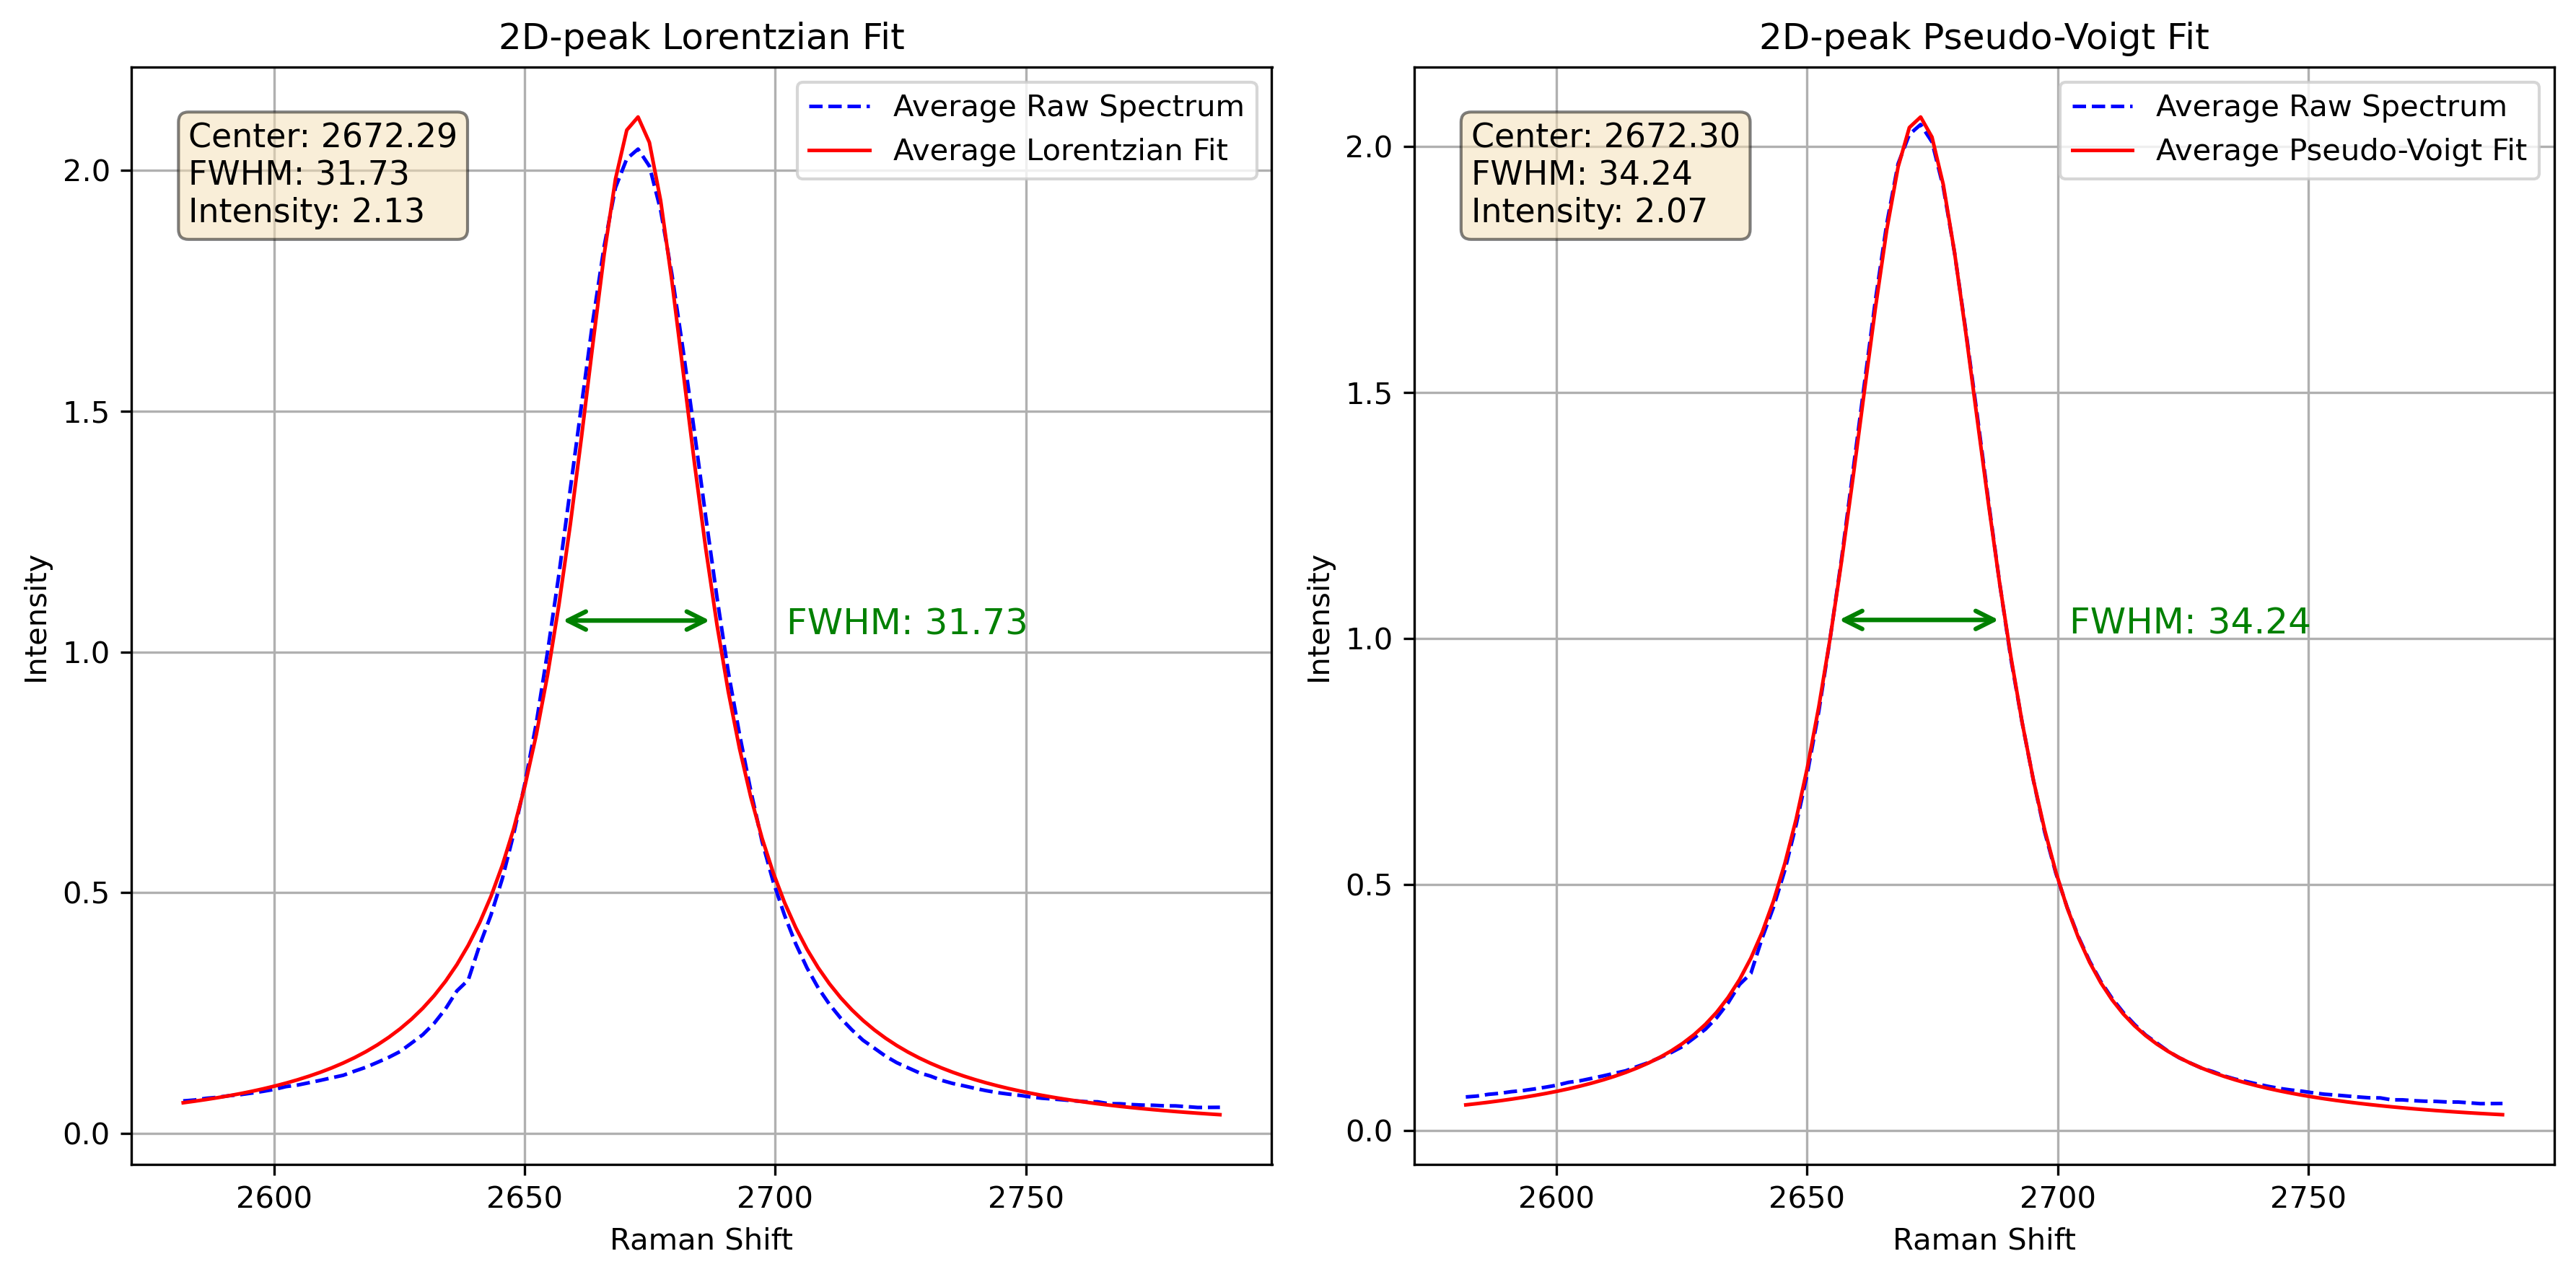

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from lmfit.models import LorentzianModel, PseudoVoigtModel

GRAPHENEPEAKS = [
    {"prefix": "D", "range": {"min": 1290.0, "max": 1420.0}},
    {"prefix": "G", "range": {"min": 1480.0, "max": 1700.0}},
    {"prefix": "twoD", "range": {"min": 2580.0, "max": 2790.0}},
]

# Define the relative file path from the notebook's location
file_path = "./Data/RawData/1615_rtAC_hotAc.txt"

# Check if the file exists
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")

# Read the first line to get Raman shift values
with open(file_path, "r") as file:
    raman_shift_values = [float(value) for value in file.readline().split()]

# Read the rest of the file into a DataFrame, skipping the first line
df = pd.read_csv(file_path, sep="\s+", header=None, skiprows=1)
df.columns = ["mapX", "mapY"] + [f"{raman_shift:.0f}" for raman_shift in raman_shift_values]

def normalize_spectrum(spectrum, raman_shift_values, peak_range):
    mask = (raman_shift_values >= peak_range['min']) & (raman_shift_values <= peak_range['max'])
    g_peak_intensity = np.max(spectrum[mask])
    return spectrum / g_peak_intensity

normalized_spectra = df.iloc[:, 2:].apply(lambda row: normalize_spectrum(row.to_numpy(), np.array(raman_shift_values), GRAPHENEPEAKS[1]['range']), axis=1)
normalized_spectra = pd.DataFrame(normalized_spectra.tolist(), columns=df.columns[2:])

pseudo_voigt_model = PseudoVoigtModel(prefix=GRAPHENEPEAKS[2]['prefix'])
lorentz_model = LorentzianModel(prefix=GRAPHENEPEAKS[2]['prefix'])

def fit_twoD_peak(data, x, peak_range, model):
    mask = (x >= peak_range['min']) & (x <= peak_range['max'])
    x_range = x[mask]
    y_range = data[mask]
    params = model.guess(y_range, x=x_range)
    result = model.fit(y_range, params, x=x_range)
    return result, result.params

fitted_spectra_pseudo_voigt = pd.DataFrame(columns=df.columns[2:], index=df.index)
fitted_spectra_lorentz = pd.DataFrame(columns=df.columns[2:], index=df.index)

parameters_list = []

for index, row in normalized_spectra.iterrows():
    spectrum_data = row.to_numpy()
    peak_result_pseudo_voigt, params_pseudo_voigt = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[2]['range'], pseudo_voigt_model)
    peak_result_lorentz, params_lorentz = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[2]['range'], lorentz_model)
    fitted_spectra_pseudo_voigt.loc[index, [f"{val:.0f}" for val in peak_result_pseudo_voigt.userkws['x']]] = peak_result_pseudo_voigt.best_fit
    fitted_spectra_lorentz.loc[index, [f"{val:.0f}" for val in peak_result_lorentz.userkws['x']]] = peak_result_lorentz.best_fit
    
    parameters_list.append({
        'Index': index, 
        'Model': 'PseudoVoigt',
        'Center': params_pseudo_voigt[GRAPHENEPEAKS[2]['prefix'] + 'center'].value,
        'FWHM': params_pseudo_voigt[GRAPHENEPEAKS[2]['prefix'] + 'fwhm'].value,
        'Height': params_pseudo_voigt[GRAPHENEPEAKS[2]['prefix'] + 'height'].value
    })
    
    parameters_list.append({
        'Index': index, 
        'Model': 'Lorentzian',
        'Center': params_lorentz[GRAPHENEPEAKS[2]['prefix'] + 'center'].value,
        'FWHM': params_lorentz[GRAPHENEPEAKS[2]['prefix'] + 'fwhm'].value,
        'Height': params_lorentz[GRAPHENEPEAKS[2]['prefix'] + 'height'].value
    })
    
    mask = (np.array(raman_shift_values) >= GRAPHENEPEAKS[2]['range']['min']) & (np.array(raman_shift_values) <= GRAPHENEPEAKS[2]['range']['max'])

parameters = pd.DataFrame(parameters_list)

# Drop the 'Index' column
parameters = parameters.drop(columns=['Index'])

# Calculate the averages for each parameter and model
average_parameters = parameters.groupby('Model').mean().T

# Rename the index for clarity
average_parameters.index = ['CENTER', 'FWHM', 'INTENSITY']

# Display the comparison table
#print(average_parameters)

avg_fitted_spectrum_pseudo_voigt = fitted_spectra_pseudo_voigt.mean(axis=0)
avg_fitted_spectrum_lorentz = fitted_spectra_lorentz.mean(axis=0)
avg_raw_spectrum = normalized_spectra.mean(axis=0)

# Create the figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Set common grid line intervals
x_major_ticks = np.arange(2600, 2800, 50)
y_major_ticks = np.arange(0, 2.5, 0.5)

# Plot for the Lorentzian fit
axs[0].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1.2, color='blue')
axs[0].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_lorentz[mask], label='Average Lorentzian Fit', linestyle='-', linewidth=1.2, color='red')
axs[0].set_title('2D-peak Lorentzian Fit')
axs[0].set_xlabel('Raman Shift')
axs[0].set_ylabel('Intensity')
axs[0].legend()
axs[0].grid(True)


# Set the major ticks
axs[0].set_xticks(x_major_ticks)
axs[0].set_yticks(y_major_ticks)

# Annotate Lorentzian parameters
center_lor = average_parameters.loc['CENTER', 'Lorentzian']
fwhm_lor = average_parameters.loc['FWHM', 'Lorentzian']
intensity_lor = average_parameters.loc['INTENSITY', 'Lorentzian']

# Calculate the start and end points for the FWHM arrow
fwhm_start_lor = center_lor - fwhm_lor / 2
fwhm_end_lor = center_lor + fwhm_lor / 2

# Add the arrow for the FWHM
arrow_lor = patches.FancyArrowPatch((fwhm_start_lor, intensity_lor / 2), (fwhm_end_lor, intensity_lor / 2),
                                    arrowstyle='<->', mutation_scale=15, color='green', linewidth=1.5
                                   )
axs[0].add_patch(arrow_lor)
axs[0].annotate(f'FWHM: {fwhm_lor:.2f}', 
                xy=(center_lor, intensity_lor / 2), 
                xytext=(center_lor + 30, intensity_lor / 2),  # Adjust the +30 value as needed
                fontsize=12, 
                va='center_baseline',
                ha='left',
                color='green')

# Annotate Lorentzian parameters
textstr_lor = '\n'.join((
    f"Center: {average_parameters.loc['CENTER', 'Lorentzian']:.2f}",
    f"FWHM: {average_parameters.loc['FWHM', 'Lorentzian']:.2f}",
    f"Intensity: {average_parameters.loc['INTENSITY', 'Lorentzian']:.2f}"))
axs[0].text(0.05, 0.95, textstr_lor, transform=axs[0].transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))



# Plot for the Pseudo-Voigt fit
axs[1].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1.2, color='blue')
axs[1].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_pseudo_voigt[mask], label='Average Pseudo-Voigt Fit', linestyle='-', linewidth=1.2, color='red')
axs[1].set_title('2D-peak Pseudo-Voigt Fit')
axs[1].set_xlabel('Raman Shift')
axs[1].set_ylabel('Intensity')
axs[1].legend()
axs[1].grid(True)

# Set the major ticks
axs[1].set_xticks(x_major_ticks)
axs[1].set_yticks(y_major_ticks)

# Annotate Pseudo-Voigt parameters
center_pv = average_parameters.loc['CENTER', 'PseudoVoigt']
fwhm_pv = average_parameters.loc['FWHM', 'PseudoVoigt']
intensity_pv = average_parameters.loc['INTENSITY', 'PseudoVoigt']

# Calculate the start and end points for the FWHM arrow
fwhm_start_pv = center_pv - fwhm_pv / 2
fwhm_end_pv = center_pv + fwhm_pv / 2

# Add the arrow for the FWHM
arrow_pv = patches.FancyArrowPatch((fwhm_start_pv, intensity_pv / 2), (fwhm_end_pv, intensity_pv / 2),
                                    arrowstyle='<->', mutation_scale=15, color='green', linewidth=1.5
                                   )
axs[1].add_patch(arrow_pv)
axs[1].annotate(f'FWHM: {fwhm_pv:.2f}', 
                xy=(center_pv, intensity_pv / 2), 
                xytext=(center_pv + 30, intensity_pv / 2),  # Adjust the +30 value as needed
                fontsize=12, 
                va='center_baseline',
                ha='left',
                color='green')

# Annotate Pseudo-Voigt parameters
textstr_pv = '\n'.join((
    f"Center: {average_parameters.loc['CENTER', 'PseudoVoigt']:.2f}",
    f"FWHM: {average_parameters.loc['FWHM', 'PseudoVoigt']:.2f}",
    f"Intensity: {average_parameters.loc['INTENSITY', 'PseudoVoigt']:.2f}"))
axs[1].text(0.05, 0.95, textstr_pv, transform=axs[1].transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


# Define the relative file path from the notebook's location
save_dir = "./Data/Images/"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)
    print(f"The directory '{save_dir}' has been created.")
else:
    print(f"The path '{save_dir}' already exists.")
    
# Save the figure   
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'Figure2d.png'), dpi=300)

# Display the plot
plt.show()

#### 2D Baseline Corrected and Time Measured

Define the funtions

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy import sparse
from scipy.sparse.linalg import spsolve
from lmfit.models import LorentzianModel, PseudoVoigtModel
from concurrent.futures import ThreadPoolExecutor
import time

def baseline_als(y, lam=20000000, p=0.01, niter=100):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

def normalize_spectrum(row, raman_shift_values, peak_range):
    mask = (raman_shift_values >= peak_range['min']) & (raman_shift_values <= peak_range['max'])
    g_peak_intensity = np.max(row[mask])
    return row / g_peak_intensity

def fit_twoD_peak(data, x, peak_range, model):
    mask = (x >= peak_range['min']) & (x <= peak_range['max'])
    x_range = x[mask]
    y_range = data[mask]
    params = model.guess(y_range, x=x_range)
    result = model.fit(y_range, params, x=x_range)
    return result, result.params


GRAPHENEPEAKS = [
    {"prefix": "D", "range": {"min": 1290.0, "max": 1420.0}},
    {"prefix": "G", "range": {"min": 1480.0, "max": 1700.0}},
    {"prefix": "twoD", "range": {"min": 2580.0, "max": 2790.0}},
]


# Define the relative file path from the notebook's location
file_path = "./Data/RawData/1615_rtAC_hotAc.txt"

# Check if the file exists
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")
    raise FileNotFoundError(f"The file '{file_path}' does not exist.")

# Read the first line to get Raman shift values
with open(file_path, "r") as file:
    raman_shift_values = [float(value) for value in file.readline().split()]

# Read the rest of the file into a DataFrame, skipping the first line
df = pd.read_csv(file_path, sep="\s+", header=None, skiprows=1)
df.columns = ["mapX", "mapY"] + [f"{raman_shift:.0f}" for raman_shift in raman_shift_values]


The file './Data/RawData/1615_rtAC_hotAc.txt' exists.


The path './Data/Images/' already exists.


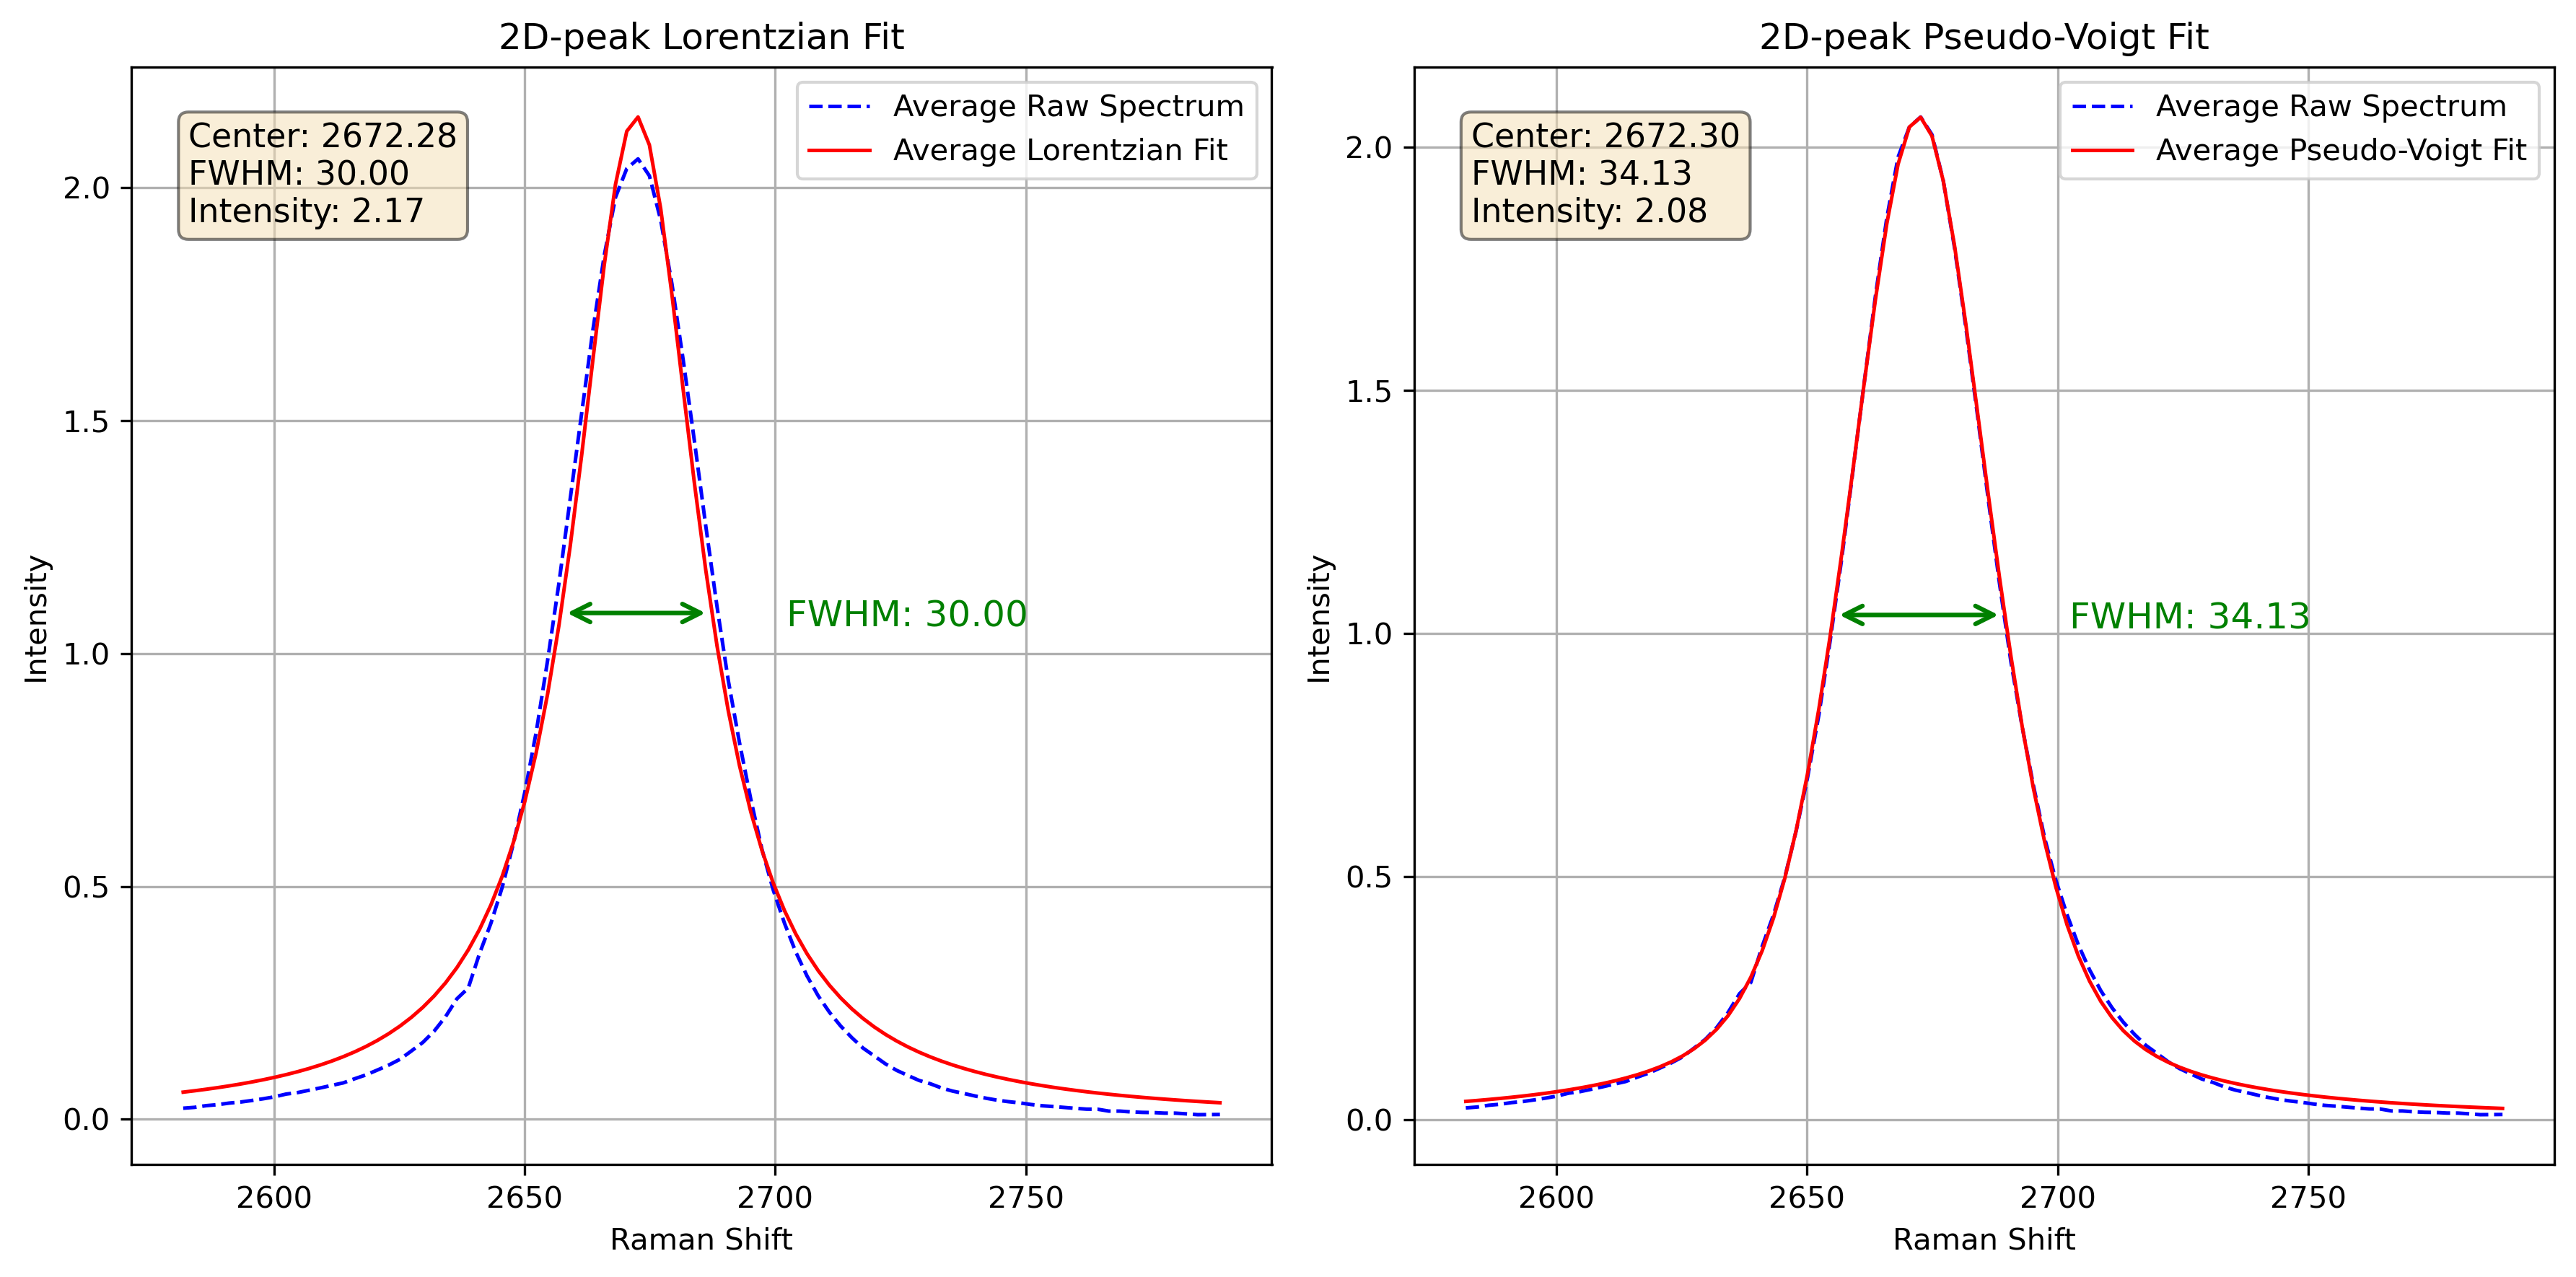

In [13]:
# Apply baseline correction and normalization
corrected_spectra = df.iloc[:, 2:].apply(lambda row: row.to_numpy() - baseline_als(row.to_numpy()), axis=1)

# Normalize each spectrum
normalized_spectra = corrected_spectra.apply(normalize_spectrum, args=(np.array(raman_shift_values), GRAPHENEPEAKS[1]['range']))

# Convert normalized spectra back to DataFrame
normalized_spectra = pd.DataFrame(normalized_spectra.tolist(), columns=df.columns[2:])

# Now you can proceed with fitting, plotting, etc.
pseudo_voigt_model = PseudoVoigtModel(prefix=GRAPHENEPEAKS[2]['prefix'])
lorentz_model = LorentzianModel(prefix=GRAPHENEPEAKS[2]['prefix'])


fitted_spectra_pseudo_voigt = pd.DataFrame(columns=df.columns[2:], index=df.index)
fitted_spectra_lorentz = pd.DataFrame(columns=df.columns[2:], index=df.index)

parameters_list = []

for index, row in normalized_spectra.iterrows():
    spectrum_data = row.values  # Access the NumPy array directly using .values
    peak_result_pseudo_voigt, params_pseudo_voigt = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[2]['range'], pseudo_voigt_model)
    peak_result_lorentz, params_lorentz = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[2]['range'], lorentz_model)
    fitted_spectra_pseudo_voigt.loc[index, [f"{val:.0f}" for val in peak_result_pseudo_voigt.userkws['x']]] = peak_result_pseudo_voigt.best_fit
    fitted_spectra_lorentz.loc[index, [f"{val:.0f}" for val in peak_result_lorentz.userkws['x']]] = peak_result_lorentz.best_fit
    
    parameters_list.append({
        'Index': index, 
        'Model': 'PseudoVoigt',
        'Center': params_pseudo_voigt[GRAPHENEPEAKS[2]['prefix'] + 'center'].value,
        'FWHM': params_pseudo_voigt[GRAPHENEPEAKS[2]['prefix'] + 'fwhm'].value,
        'Height': params_pseudo_voigt[GRAPHENEPEAKS[2]['prefix'] + 'height'].value
    })
    
    parameters_list.append({
        'Index': index, 
        'Model': 'Lorentzian',
        'Center': params_lorentz[GRAPHENEPEAKS[2]['prefix'] + 'center'].value,
        'FWHM': params_lorentz[GRAPHENEPEAKS[2]['prefix'] + 'fwhm'].value,
        'Height': params_lorentz[GRAPHENEPEAKS[2]['prefix'] + 'height'].value
    })

mask = (np.array(raman_shift_values) >= GRAPHENEPEAKS[2]['range']['min']) & (np.array(raman_shift_values) <= GRAPHENEPEAKS[2]['range']['max'])

parameters = pd.DataFrame(parameters_list)

# Drop the 'Index' column
parameters = parameters.drop(columns=['Index'])

# Calculate the averages for each parameter and model
average_parameters = parameters.groupby('Model').mean().T

# Rename the index for clarity
average_parameters.index = ['CENTER', 'FWHM', 'INTENSITY']

# Display the comparison table
#print(average_parameters)

avg_fitted_spectrum_pseudo_voigt = fitted_spectra_pseudo_voigt.mean(axis=0)
avg_fitted_spectrum_lorentz = fitted_spectra_lorentz.mean(axis=0)
avg_raw_spectrum = normalized_spectra.mean(axis=0)

# Create the figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Set common grid line intervals
x_major_ticks = np.arange(2600, 2800, 50)
y_major_ticks = np.arange(0, 2.5, 0.5)

# Plot for the Lorentzian fit
axs[0].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1.2, color='blue')
axs[0].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_lorentz[mask], label='Average Lorentzian Fit', linestyle='-', linewidth=1.2, color='red')
axs[0].set_title('2D-peak Lorentzian Fit')
axs[0].set_xlabel('Raman Shift')
axs[0].set_ylabel('Intensity')
axs[0].legend()
axs[0].grid(True)

# Set the major ticks
axs[0].set_xticks(x_major_ticks)
axs[0].set_yticks(y_major_ticks)

# Annotate Lorentzian parameters
center_lor = average_parameters.loc['CENTER', 'Lorentzian']
fwhm_lor = average_parameters.loc['FWHM', 'Lorentzian']
intensity_lor = average_parameters.loc['INTENSITY', 'Lorentzian']

# Calculate the start and end points for the FWHM arrow
fwhm_start_lor = center_lor - fwhm_lor / 2
fwhm_end_lor = center_lor + fwhm_lor / 2

# Add the arrow for the FWHM
arrow_lor = patches.FancyArrowPatch((fwhm_start_lor, intensity_lor / 2), (fwhm_end_lor, intensity_lor / 2),
                                    arrowstyle='<->', mutation_scale=15, color='green', linewidth=1.5
                                   )
axs[0].add_patch(arrow_lor)
axs[0].annotate(f'FWHM: {fwhm_lor:.2f}', 
                xy=(center_lor, intensity_lor / 2), 
                xytext=(center_lor + 30, intensity_lor / 2),  # Adjust the +30 value as needed
                fontsize=12, 
                va='center_baseline',
                ha='left',
                color='green')

# Annotate Lorentzian parameters
textstr_lor = '\n'.join((
    f"Center: {average_parameters.loc['CENTER', 'Lorentzian']:.2f}",
    f"FWHM: {average_parameters.loc['FWHM', 'Lorentzian']:.2f}",
    f"Intensity: {average_parameters.loc['INTENSITY', 'Lorentzian']:.2f}"))
axs[0].text(0.05, 0.95, textstr_lor, transform=axs[0].transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot for the Pseudo-Voigt fit
axs[1].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1.2, color='blue')
axs[1].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_pseudo_voigt[mask], label='Average Pseudo-Voigt Fit', linestyle='-', linewidth=1.2, color='red')
axs[1].set_title('2D-peak Pseudo-Voigt Fit')
axs[1].set_xlabel('Raman Shift')
axs[1].set_ylabel('Intensity')
axs[1].legend()
axs[1].grid(True)

# Set the major ticks
axs[1].set_xticks(x_major_ticks)
axs[1].set_yticks(y_major_ticks)

# Annotate Pseudo-Voigt parameters
center_pv = average_parameters.loc['CENTER', 'PseudoVoigt']
fwhm_pv = average_parameters.loc['FWHM', 'PseudoVoigt']
intensity_pv = average_parameters.loc['INTENSITY', 'PseudoVoigt']

# Calculate the start and end points for the FWHM arrow
fwhm_start_pv = center_pv - fwhm_pv / 2
fwhm_end_pv = center_pv + fwhm_pv / 2

# Add the arrow for the FWHM
arrow_pv = patches.FancyArrowPatch((fwhm_start_pv, intensity_pv / 2), (fwhm_end_pv, intensity_pv / 2),
                                    arrowstyle='<->', mutation_scale=15, color='green', linewidth=1.5
                                   )
axs[1].add_patch(arrow_pv)
axs[1].annotate(f'FWHM: {fwhm_pv:.2f}', 
                xy=(center_pv, intensity_pv / 2), 
                xytext=(center_pv + 30, intensity_pv / 2),  # Adjust the +30 value as needed
                fontsize=12, 
                va='center_baseline',
                ha='left',
                color='green')

# Annotate Pseudo-Voigt parameters
textstr_pv = '\n'.join((
    f"Center: {average_parameters.loc['CENTER', 'PseudoVoigt']:.2f}",
    f"FWHM: {average_parameters.loc['FWHM', 'PseudoVoigt']:.2f}",
    f"Intensity: {average_parameters.loc['INTENSITY', 'PseudoVoigt']:.2f}"))
axs[1].text(0.05, 0.95, textstr_pv, transform=axs[1].transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Define the relative file path from the notebook's location
save_dir = "./Data/Images/"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)
    print(f"The directory '{save_dir}' has been created.")
else:
    print(f"The path '{save_dir}' already exists.")
    
# Save the figure   
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'Figure2d_baselineCorrected.png'), dpi=300)

# Display the plot
plt.show()

In [ ]:
# Assuming you want to print the intensities for the Pseudo-Voigt fit (you can do similarly for Lorentzian)
for index, row in fitted_spectra_pseudo_voigt.iterrows():
    intensity_pv = row.loc[[f"{val:.0f}" for val in np.array(raman_shift_values)]].max()
    print(f"Spectrum {index}: Intensity of 2D peak (Pseudo-Voigt): {intensity_pv:.2f}")


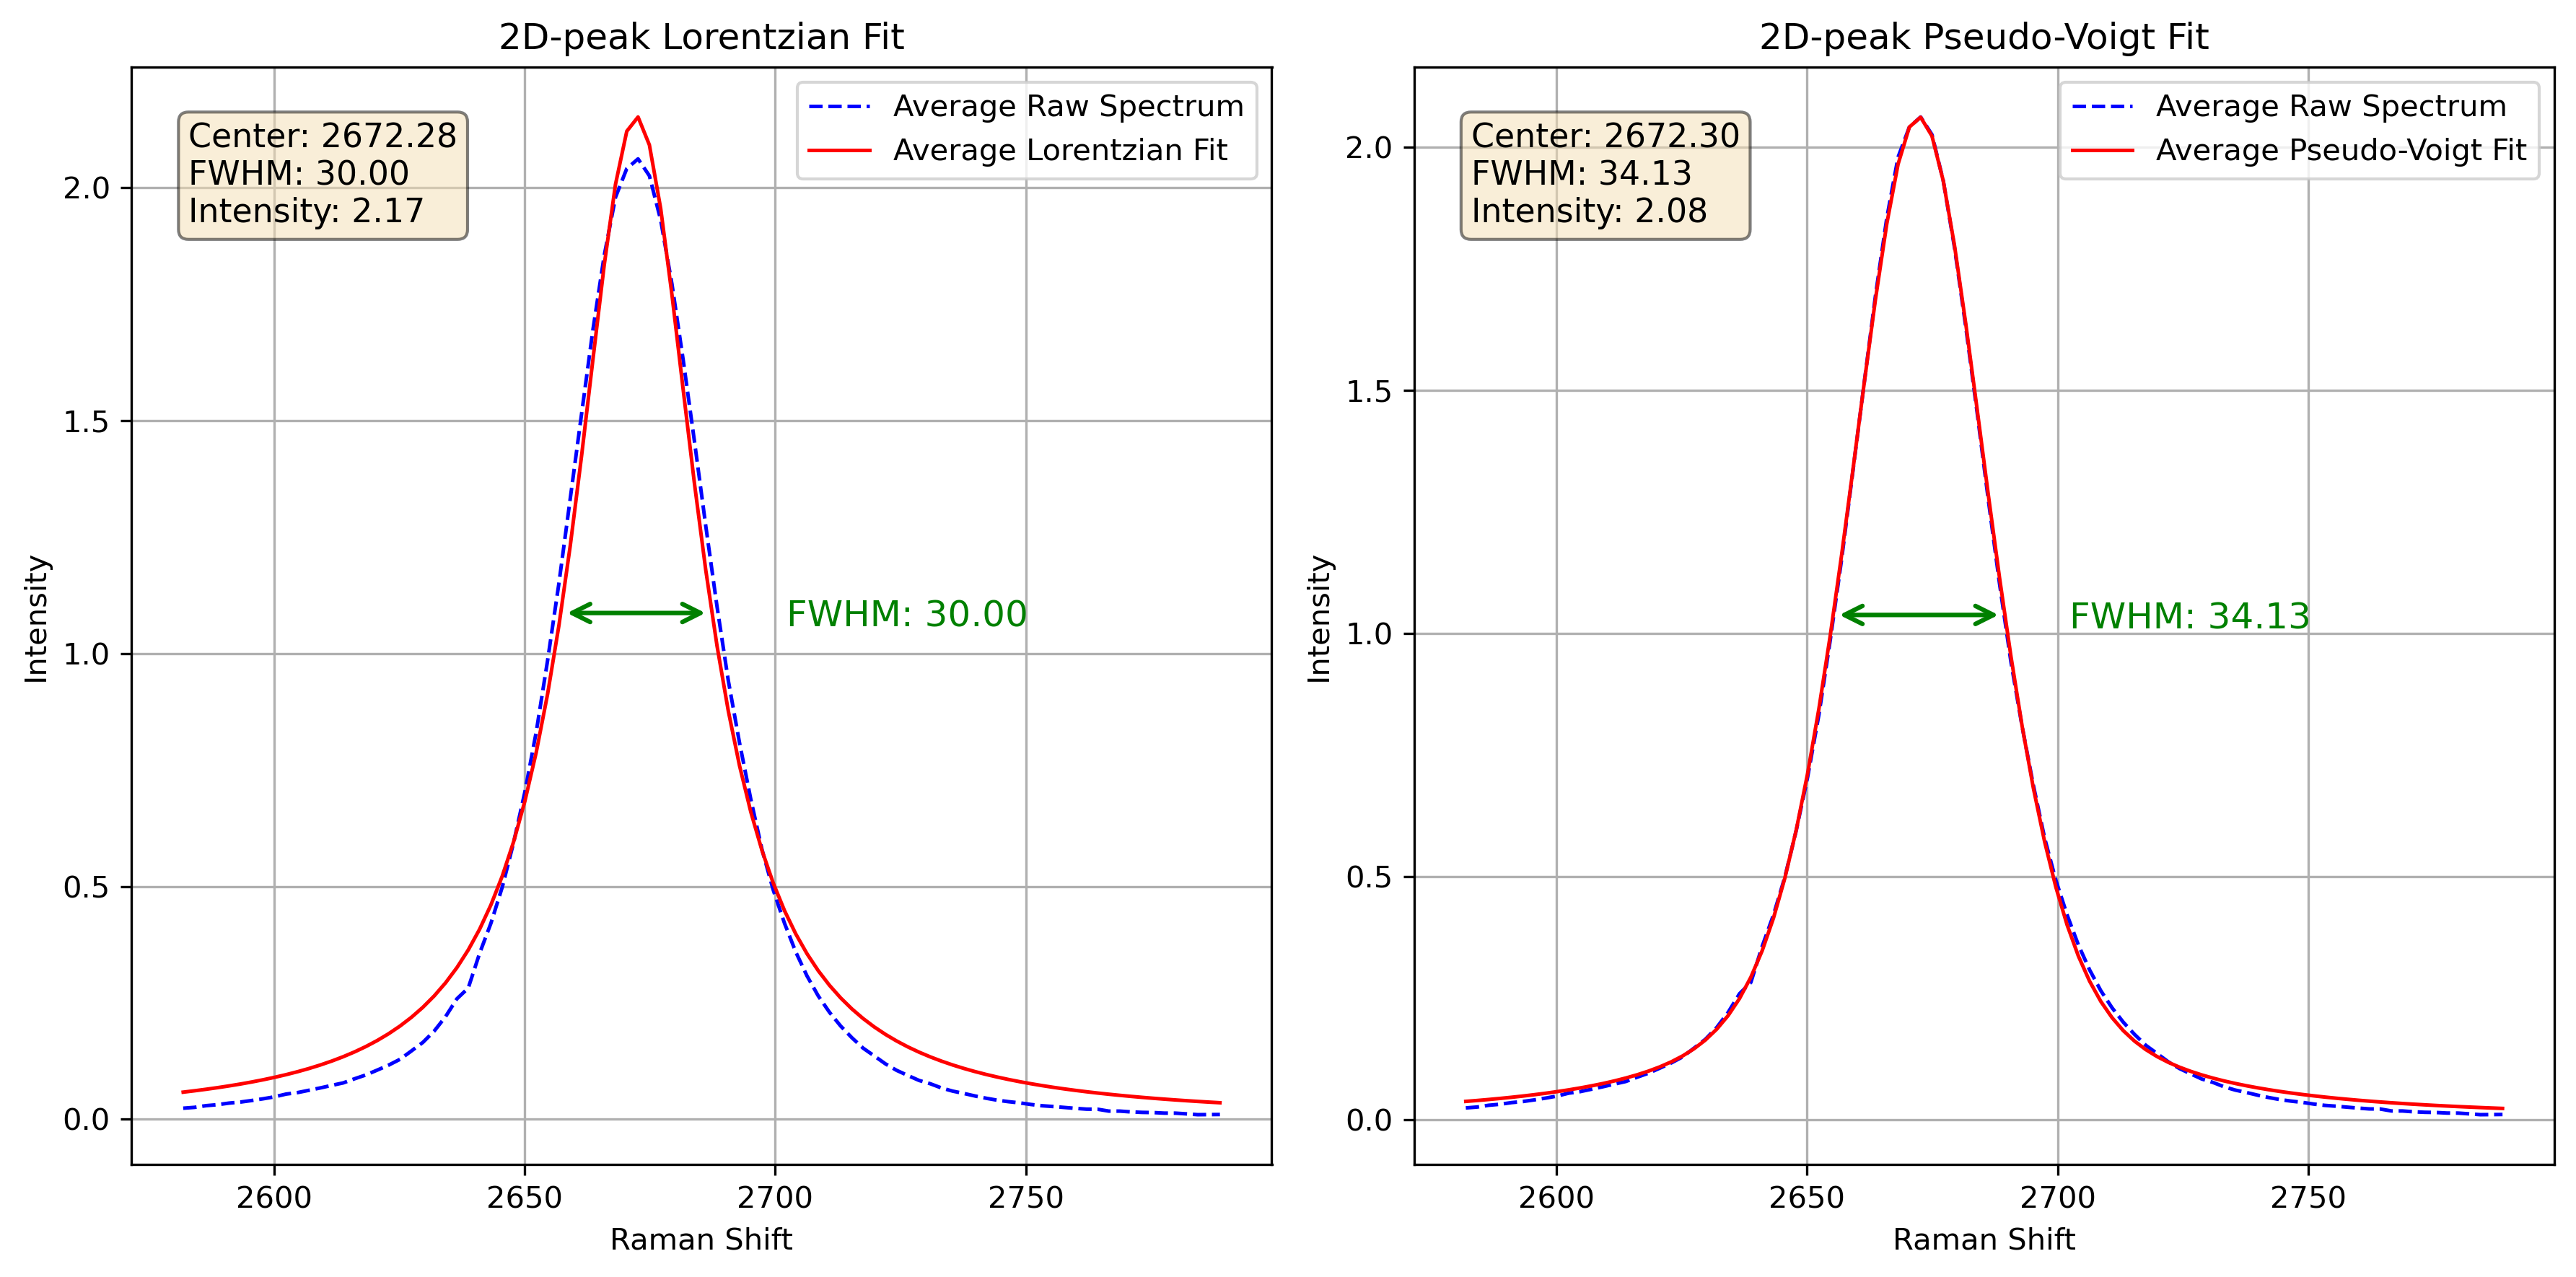

Total baseline correction time: 18.2016 seconds
Total normalization time: 0.0079 seconds


In [15]:
# Time tracking lists
baseline_times = []
normalization_times = []


baseline_corrected_spectra = []
for row in df.iloc[:, 2:].itertuples(index=False):
    row_array = np.array(row)
    start_time = time.time()
    corrected = row_array - baseline_als(row_array)
    end_time = time.time()
    baseline_times.append(end_time - start_time)
    baseline_corrected_spectra.append(corrected)

    
normalized_spectra = []
for corrected_row in baseline_corrected_spectra:
    start_time = time.time()
    normalized = normalize_spectrum(corrected_row, np.array(raman_shift_values), GRAPHENEPEAKS[1]['range'])
    end_time = time.time()
    normalization_times.append(end_time - start_time)
    normalized_spectra.append(normalized)

# Convert normalized spectra back to DataFrame
normalized_spectra = pd.DataFrame(normalized_spectra, columns=df.columns[2:])

pseudo_voigt_model = PseudoVoigtModel(prefix=GRAPHENEPEAKS[2]['prefix'])
lorentz_model = LorentzianModel(prefix=GRAPHENEPEAKS[2]['prefix'])


# Function to fit a single spectrum
def fit_spectrum(index, row, raman_shift_values):
    spectrum_data = row.values
    peak_result_pseudo_voigt, params_pseudo_voigt = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[2]['range'], pseudo_voigt_model)
    peak_result_lorentz, params_lorentz = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[2]['range'], lorentz_model)
    
    return index, peak_result_pseudo_voigt, params_pseudo_voigt, peak_result_lorentz, params_lorentz

# Lists to store results
fitted_spectra_pseudo_voigt = pd.DataFrame(columns=df.columns[2:], index=df.index)
fitted_spectra_lorentz = pd.DataFrame(columns=df.columns[2:], index=df.index)
parameters_list = []

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=None) as executor:
    futures = [executor.submit(fit_spectrum, index, row, np.array(raman_shift_values)) for index, row in normalized_spectra.iterrows()]
    for future in futures:
        index, peak_result_pseudo_voigt, params_pseudo_voigt, peak_result_lorentz, params_lorentz = future.result()
        fitted_spectra_pseudo_voigt.loc[index, [f"{val:.0f}" for val in peak_result_pseudo_voigt.userkws['x']]] = peak_result_pseudo_voigt.best_fit
        fitted_spectra_lorentz.loc[index, [f"{val:.0f}" for val in peak_result_lorentz.userkws['x']]] = peak_result_lorentz.best_fit
        
        parameters_list.append({
            'Index': index, 
            'Model': 'PseudoVoigt',
            'Center': params_pseudo_voigt[GRAPHENEPEAKS[2]['prefix'] + 'center'].value,
            'FWHM': params_pseudo_voigt[GRAPHENEPEAKS[2]['prefix'] + 'fwhm'].value,
            'Height': params_pseudo_voigt[GRAPHENEPEAKS[2]['prefix'] + 'height'].value
        })
        
        parameters_list.append({
            'Index': index, 
            'Model': 'Lorentzian',
            'Center': params_lorentz[GRAPHENEPEAKS[2]['prefix'] + 'center'].value,
            'FWHM': params_lorentz[GRAPHENEPEAKS[2]['prefix'] + 'fwhm'].value,
            'Height': params_lorentz[GRAPHENEPEAKS[2]['prefix'] + 'height'].value
        })

mask = (np.array(raman_shift_values) >= GRAPHENEPEAKS[2]['range']['min']) & (np.array(raman_shift_values) <= GRAPHENEPEAKS[2]['range']['max'])

parameters = pd.DataFrame(parameters_list)

# Drop the 'Index' column
parameters = parameters.drop(columns=['Index'])

# Calculate the averages for each parameter and model
average_parameters = parameters.groupby('Model').mean().T

# Rename the index for clarity
average_parameters.index = ['CENTER', 'FWHM', 'INTENSITY']

# Display the comparison table
#print(average_parameters)

avg_fitted_spectrum_pseudo_voigt = fitted_spectra_pseudo_voigt.mean(axis=0)
avg_fitted_spectrum_lorentz = fitted_spectra_lorentz.mean(axis=0)
avg_raw_spectrum = normalized_spectra.mean(axis=0)

# Create the figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Set common grid line intervals
x_major_ticks = np.arange(2600, 2800, 50)
y_major_ticks = np.arange(0, 2.5, 0.5)

# Plot for the Lorentzian fit
axs[0].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1.2, color='blue')
axs[0].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_lorentz[mask], label='Average Lorentzian Fit', linestyle='-', linewidth=1.2, color='red')
axs[0].set_title('2D-peak Lorentzian Fit')
axs[0].set_xlabel('Raman Shift')
axs[0].set_ylabel('Intensity')
axs[0].legend()
axs[0].grid(True)

# Set the major ticks
axs[0].set_xticks(x_major_ticks)
axs[0].set_yticks(y_major_ticks)

# Annotate Lorentzian parameters
center_lor = average_parameters.loc['CENTER', 'Lorentzian']
fwhm_lor = average_parameters.loc['FWHM', 'Lorentzian']
intensity_lor = average_parameters.loc['INTENSITY', 'Lorentzian']

# Calculate the start and end points for the FWHM arrow
fwhm_start_lor = center_lor - fwhm_lor / 2
fwhm_end_lor = center_lor + fwhm_lor / 2

# Add the arrow for the FWHM
arrow_lor = patches.FancyArrowPatch((fwhm_start_lor, intensity_lor / 2), (fwhm_end_lor, intensity_lor / 2),
                                    arrowstyle='<->', mutation_scale=15, color='green', linewidth=1.5
                                   )
axs[0].add_patch(arrow_lor)
axs[0].annotate(f'FWHM: {fwhm_lor:.2f}', 
                xy=(center_lor, intensity_lor / 2), 
                xytext=(center_lor + 30, intensity_lor / 2),  # Adjust the +30 value as needed
                fontsize=12, 
                va='center_baseline',
                ha='left',
                color='green')

# Annotate Lorentzian parameters
textstr_lor = '\n'.join((
    f"Center: {average_parameters.loc['CENTER', 'Lorentzian']:.2f}",
    f"FWHM: {average_parameters.loc['FWHM', 'Lorentzian']:.2f}",
    f"Intensity: {average_parameters.loc['INTENSITY', 'Lorentzian']:.2f}"))
axs[0].text(0.05, 0.95, textstr_lor, transform=axs[0].transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot for the Pseudo-Voigt fit
axs[1].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1.2, color='blue')
axs[1].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_pseudo_voigt[mask], label='Average Pseudo-Voigt Fit', linestyle='-', linewidth=1.2, color='red')
axs[1].set_title('2D-peak Pseudo-Voigt Fit')
axs[1].set_xlabel('Raman Shift')
axs[1].set_ylabel('Intensity')
axs[1].legend()
axs[1].grid(True)

# Set the major ticks
axs[1].set_xticks(x_major_ticks)
axs[1].set_yticks(y_major_ticks)

# Annotate Pseudo-Voigt parameters
center_pv = average_parameters.loc['CENTER', 'PseudoVoigt']
fwhm_pv = average_parameters.loc['FWHM', 'PseudoVoigt']
intensity_pv = average_parameters.loc['INTENSITY', 'PseudoVoigt']

# Calculate the start and end points for the FWHM arrow
fwhm_start_pv = center_pv - fwhm_pv / 2
fwhm_end_pv = center_pv + fwhm_pv / 2

# Add the arrow for the FWHM
arrow_pv = patches.FancyArrowPatch((fwhm_start_pv, intensity_pv / 2), (fwhm_end_pv, intensity_pv / 2),
                                    arrowstyle='<->', mutation_scale=15, color='green', linewidth=1.5
                                   )
axs[1].add_patch(arrow_pv)
axs[1].annotate(f'FWHM: {fwhm_pv:.2f}', 
                xy=(center_pv, intensity_pv / 2), 
                xytext=(center_pv + 30, intensity_pv / 2),  # Adjust the +30 value as needed
                fontsize=12, 
                va='center_baseline',
                ha='left',
                color='green')

# Annotate Pseudo-Voigt parameters
textstr_pv = '\n'.join((
    f"Center: {average_parameters.loc['CENTER', 'PseudoVoigt']:.2f}",
    f"FWHM: {average_parameters.loc['FWHM', 'PseudoVoigt']:.2f}",
    f"Intensity: {average_parameters.loc['INTENSITY', 'PseudoVoigt']:.2f}"))
axs[1].text(0.05, 0.95, textstr_pv, transform=axs[1].transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Save the figure
plt.tight_layout()

# Display the plot
plt.show()

# Display timing results
print(f"Total baseline correction time: {np.sum(baseline_times):.4f} seconds")
print(f"Total normalization time: {np.sum(normalization_times):.4f} seconds")


### G-Peak

Model       Lorentzian  PseudoVoigt
CENTER     1582.193084  1582.193042
FWHM         16.039214    16.039216
INTENSITY     0.977786     0.977785


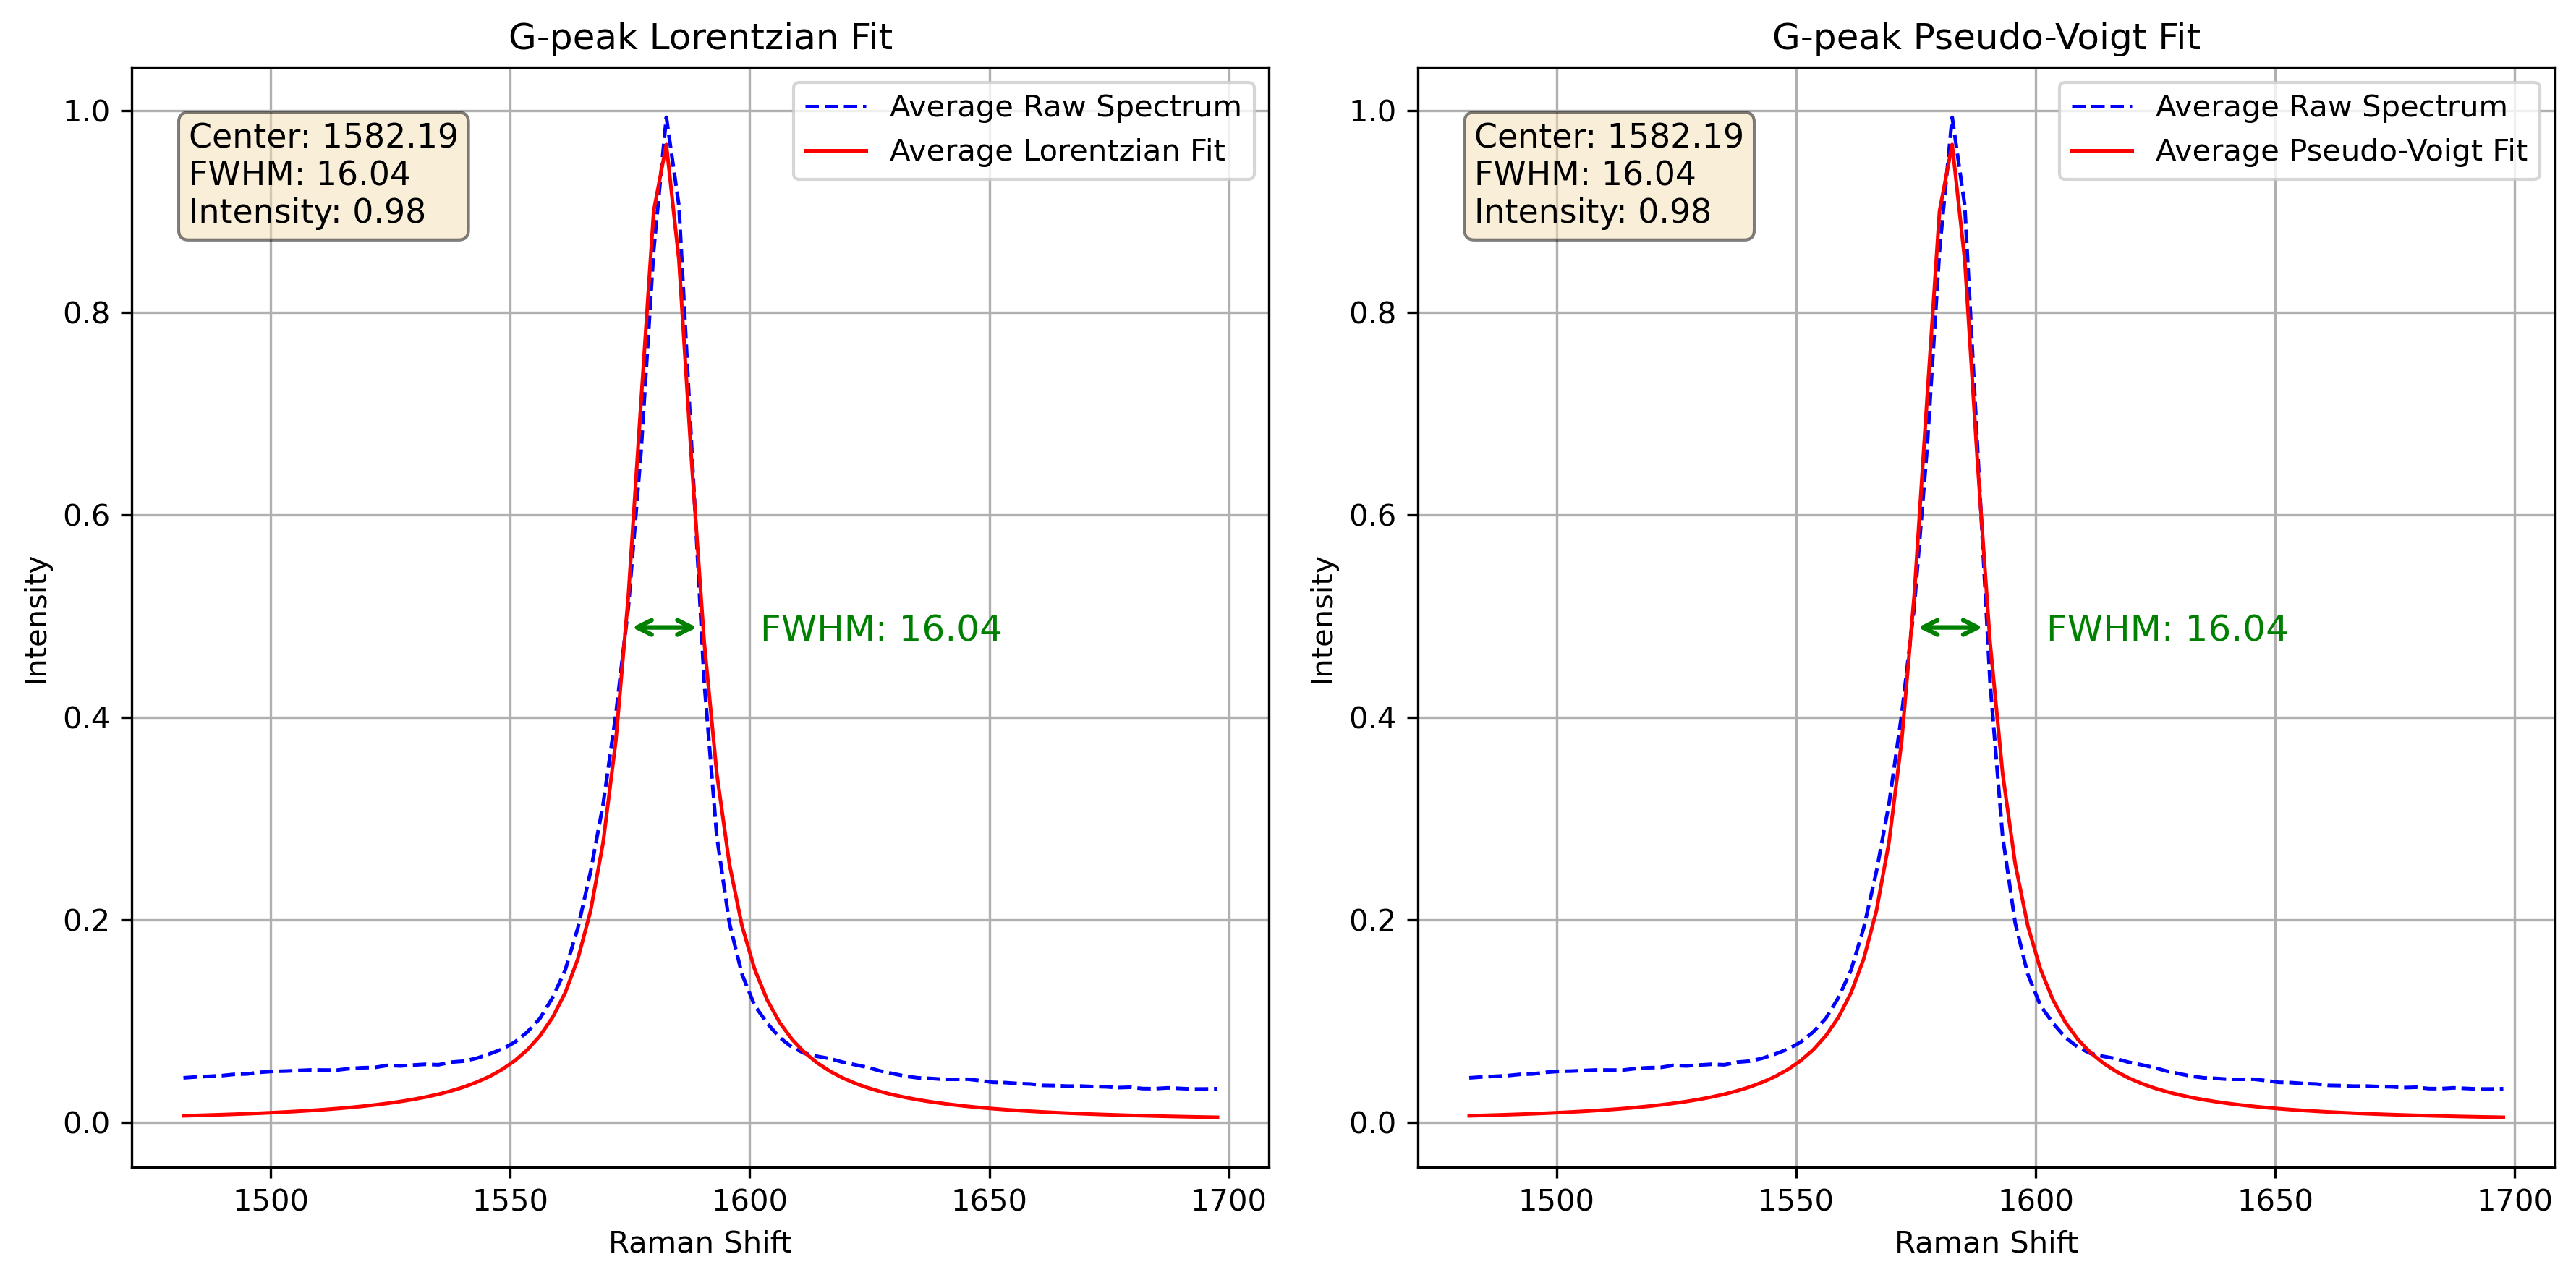

In [16]:
normalized_spectra = df.iloc[:, 2:].apply(lambda row: normalize_spectrum(row.to_numpy(), np.array(raman_shift_values), GRAPHENEPEAKS[1]['range']), axis=1)
normalized_spectra = pd.DataFrame(normalized_spectra.tolist(), columns=df.columns[2:])

# Define models
pseudo_voigt_model = PseudoVoigtModel(prefix=GRAPHENEPEAKS[1]['prefix'])
lorentz_model = LorentzianModel(prefix=GRAPHENEPEAKS[1]['prefix'])

# Fit spectra and extract parameters
fitted_spectra_pseudo_voigt = pd.DataFrame(columns=df.columns[2:], index=df.index)
fitted_spectra_lorentz = pd.DataFrame(columns=df.columns[2:], index=df.index)
parameters_list = []

for index, row in normalized_spectra.iterrows():
    spectrum_data = row.to_numpy()
    peak_result_pseudo_voigt, params_pseudo_voigt = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[1]['range'], pseudo_voigt_model)
    peak_result_lorentz, params_lorentz = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[1]['range'], lorentz_model)
    fitted_spectra_pseudo_voigt.loc[index, [f"{val:.0f}" for val in peak_result_pseudo_voigt.userkws['x']]] = peak_result_pseudo_voigt.best_fit
    fitted_spectra_lorentz.loc[index, [f"{val:.0f}" for val in peak_result_lorentz.userkws['x']]] = peak_result_lorentz.best_fit
    
    parameters_list.append({
        'Index': index, 
        'Model': 'PseudoVoigt',
        'Center': params_pseudo_voigt[GRAPHENEPEAKS[1]['prefix'] + 'center'].value,
        'FWHM': params_pseudo_voigt[GRAPHENEPEAKS[1]['prefix'] + 'fwhm'].value,
        'Height': params_pseudo_voigt[GRAPHENEPEAKS[1]['prefix'] + 'height'].value
    })
    
    parameters_list.append({
        'Index': index, 
        'Model': 'Lorentzian',
        'Center': params_lorentz[GRAPHENEPEAKS[1]['prefix'] + 'center'].value,
        'FWHM': params_lorentz[GRAPHENEPEAKS[1]['prefix'] + 'fwhm'].value,
        'Height': params_lorentz[GRAPHENEPEAKS[1]['prefix'] + 'height'].value
    })

parameters = pd.DataFrame(parameters_list)
parameters = parameters.drop(columns=['Index'])

# Calculate the averages for each parameter and model
average_parameters = parameters.groupby('Model').mean().T
average_parameters.index = ['CENTER', 'FWHM', 'INTENSITY']
# Display the comparison table
print(average_parameters)

# Calculate average spectra
avg_fitted_spectrum_pseudo_voigt = fitted_spectra_pseudo_voigt.mean(axis=0)
avg_fitted_spectrum_lorentz = fitted_spectra_lorentz.mean(axis=0)
avg_raw_spectrum = normalized_spectra.mean(axis=0)

# Define the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Define the mask for the G-peak range
mask = (np.array(raman_shift_values) >= GRAPHENEPEAKS[1]['range']['min']) & (np.array(raman_shift_values) <= GRAPHENEPEAKS[1]['range']['max'])

# Plot for the Lorentzian fit
axs[0].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1.2, color='blue')
axs[0].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_lorentz[mask], label='Average Lorentzian Fit', linestyle='-', linewidth=1.2, color='red')
axs[0].set_title('G-peak Lorentzian Fit')
axs[0].set_xlabel('Raman Shift')
axs[0].set_ylabel('Intensity')
axs[0].legend()
axs[0].grid(True)

# Annotate Lorentzian parameters
center_lor = average_parameters.loc['CENTER', 'Lorentzian']
fwhm_lor = average_parameters.loc['FWHM', 'Lorentzian']
intensity_lor = average_parameters.loc['INTENSITY', 'Lorentzian']

# Add the arrow for the FWHM
fwhm_start_lor = center_lor - fwhm_lor / 2
fwhm_end_lor = center_lor + fwhm_lor / 2
arrow_lor = patches.FancyArrowPatch((fwhm_start_lor, intensity_lor / 2), (fwhm_end_lor, intensity_lor / 2),
                                    arrowstyle='<->', mutation_scale=12, color='green', linewidth=1.5)
axs[0].add_patch(arrow_lor)
axs[0].annotate(f'FWHM: {fwhm_lor:.2f}', 
                xy=(center_lor, intensity_lor / 2), 
                xytext=(center_lor + 20, intensity_lor / 2), 
                fontsize=12, 
                va='center_baseline',
                ha='left',
                color='green')

textstr_lor = '\n'.join((
    f"Center: {center_lor:.2f}",
    f"FWHM: {fwhm_lor:.2f}",
    f"Intensity: {intensity_lor:.2f}"))
axs[0].text(0.05, 0.95, textstr_lor, transform=axs[0].transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot for the Pseudo-Voigt fit
axs[1].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1.2, color='blue')
axs[1].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_pseudo_voigt[mask], label='Average Pseudo-Voigt Fit', linestyle='-', linewidth=1.2, color='red')
axs[1].set_title('G-peak Pseudo-Voigt Fit')
axs[1].set_xlabel('Raman Shift')
axs[1].set_ylabel('Intensity')
axs[1].legend()
axs[1].grid(True)


# Annotate PseudoVoigt parameters
center_pv = average_parameters.loc['CENTER', 'PseudoVoigt']
fwhm_pv = average_parameters.loc['FWHM', 'PseudoVoigt']
intensity_pv = average_parameters.loc['INTENSITY', 'PseudoVoigt']

# Add the arrow for the FWHM
fwhm_start_pv = center_pv - fwhm_pv / 2
fwhm_end_pv = center_pv + fwhm_pv / 2
arrow_pv = patches.FancyArrowPatch((fwhm_start_pv, intensity_pv / 2), (fwhm_end_pv, intensity_pv / 2),
                                    arrowstyle='<->', mutation_scale=12, color='green', linewidth=1.5)
axs[1].add_patch(arrow_pv)
axs[1].annotate(f'FWHM: {fwhm_pv:.2f}', 
                xy=(center_pv, intensity_pv / 2), 
                xytext=(center_pv + 20, intensity_pv / 2), 
                fontsize=12, 
                va='center_baseline',
                ha='left',
                color='green')

textstr_pv = '\n'.join((
    f"Center: {center_pv:.2f}",
    f"FWHM: {fwhm_pv:.2f}",
    f"Intensity: {intensity_pv:.2f}"))
axs[1].text(0.05, 0.95, textstr_pv, transform=axs[1].transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

#### G-peak Baseline corrected and Time Measured

Model       Lorentzian  PseudoVoigt
CENTER     1582.273158  1582.247562
FWHM         14.323838    14.706110
INTENSITY     1.005463     0.996280


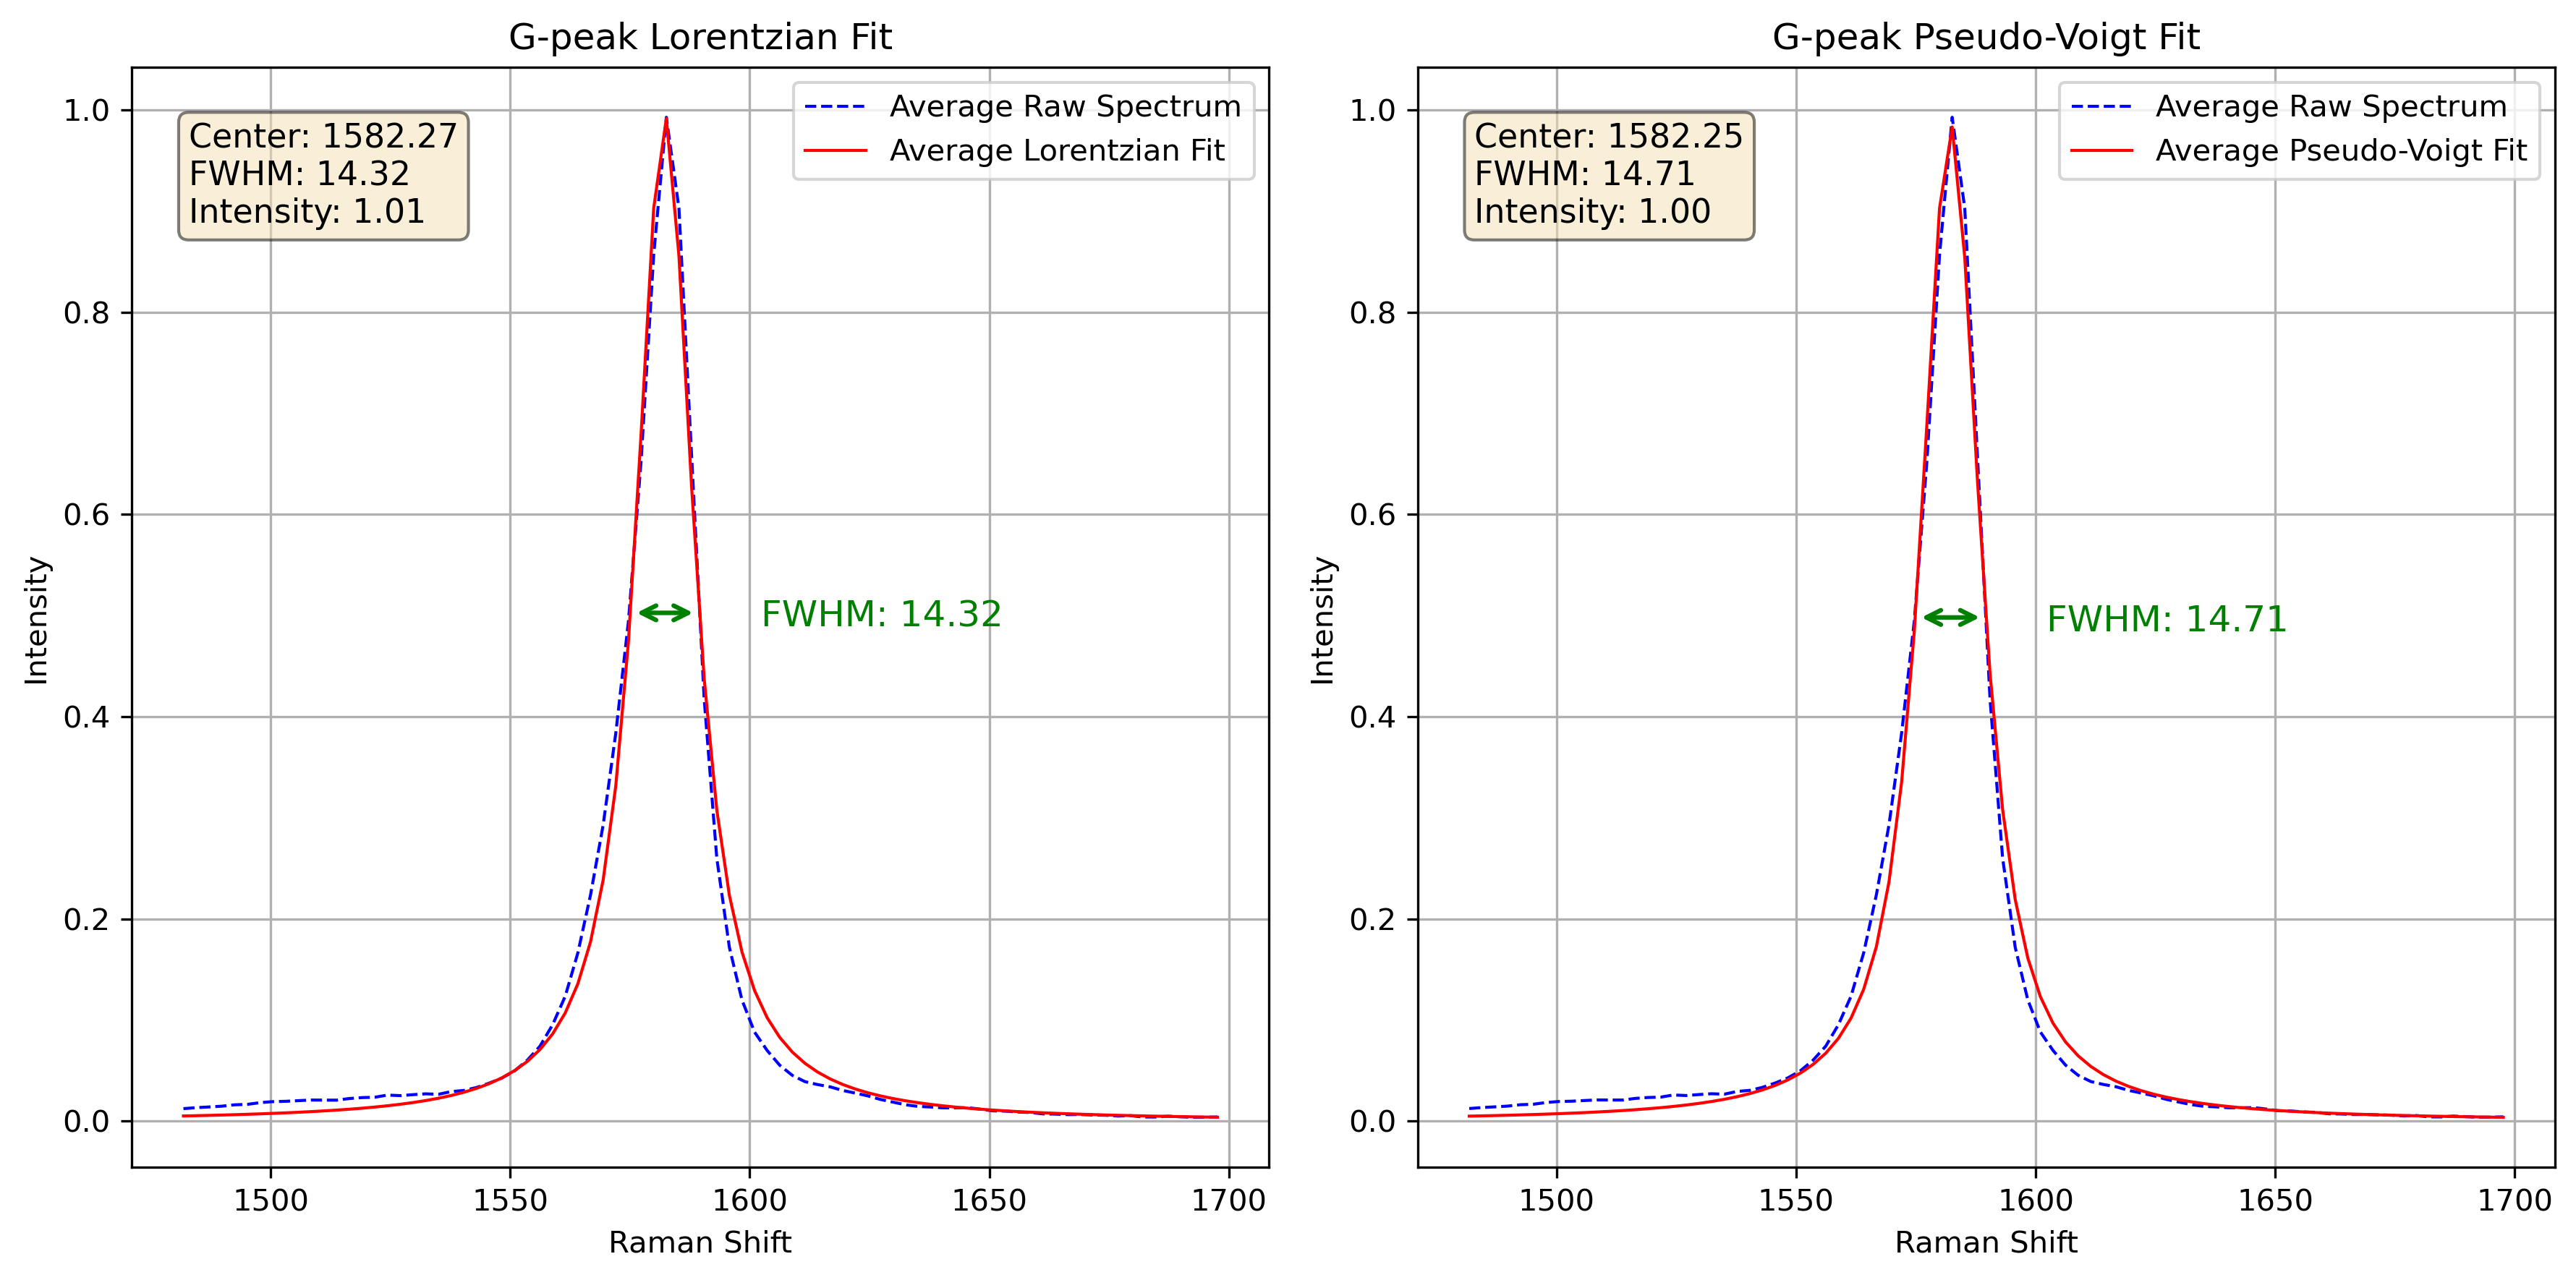

Total baseline correction time: 17.5282 seconds
Total normalization time: 0.0060 seconds


In [17]:
# Time tracking lists
baseline_times = []
normalization_times = []

# Apply baseline correction and normalization with timing
baseline_corrected_spectra = []
for row in df.iloc[:, 2:].itertuples(index=False):
    row_array = np.array(row)
    start_time = time.time()
    corrected = row_array - baseline_als(row_array)
    end_time = time.time()
    baseline_times.append(end_time - start_time)
    baseline_corrected_spectra.append(corrected)

normalized_spectra = []
for corrected_row in baseline_corrected_spectra:
    start_time = time.time()
    normalized = normalize_spectrum(corrected_row, np.array(raman_shift_values), GRAPHENEPEAKS[1]['range'])
    end_time = time.time()
    normalization_times.append(end_time - start_time)
    normalized_spectra.append(normalized)

# Convert normalized spectra back to DataFrame
normalized_spectra = pd.DataFrame(normalized_spectra, columns=df.columns[2:])

# Define models
pseudo_voigt_model = PseudoVoigtModel(prefix=GRAPHENEPEAKS[1]['prefix'])
lorentz_model = LorentzianModel(prefix=GRAPHENEPEAKS[1]['prefix'])

def fit_twoD_peak(data, x, peak_range, model):
    mask = (x >= peak_range['min']) & (x <= peak_range['max'])
    x_range = x[mask]
    y_range = data[mask]
    params = model.guess(y_range, x=x_range)
    result = model.fit(y_range, params, x=x_range)
    return result, result.params

# Fit spectra and extract parameters
fitted_spectra_pseudo_voigt = pd.DataFrame(columns=df.columns[2:], index=df.index)
fitted_spectra_lorentz = pd.DataFrame(columns=df.columns[2:], index=df.index)
parameters_list = []

for index, row in normalized_spectra.iterrows():
    spectrum_data = row.to_numpy()
    peak_result_pseudo_voigt, params_pseudo_voigt = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[1]['range'], pseudo_voigt_model)
    peak_result_lorentz, params_lorentz = fit_twoD_peak(spectrum_data, np.array(raman_shift_values), GRAPHENEPEAKS[1]['range'], lorentz_model)
    fitted_spectra_pseudo_voigt.loc[index, [f"{val:.0f}" for val in peak_result_pseudo_voigt.userkws['x']]] = peak_result_pseudo_voigt.best_fit
    fitted_spectra_lorentz.loc[index, [f"{val:.0f}" for val in peak_result_lorentz.userkws['x']]] = peak_result_lorentz.best_fit
    
    parameters_list.append({
        'Index': index, 
        'Model': 'PseudoVoigt',
        'Center': params_pseudo_voigt[GRAPHENEPEAKS[1]['prefix'] + 'center'].value,
        'FWHM': params_pseudo_voigt[GRAPHENEPEAKS[1]['prefix'] + 'fwhm'].value,
        'Height': params_pseudo_voigt[GRAPHENEPEAKS[1]['prefix'] + 'height'].value
    })
    
    parameters_list.append({
        'Index': index, 
        'Model': 'Lorentzian',
        'Center': params_lorentz[GRAPHENEPEAKS[1]['prefix'] + 'center'].value,
        'FWHM': params_lorentz[GRAPHENEPEAKS[1]['prefix'] + 'fwhm'].value,
        'Height': params_lorentz[GRAPHENEPEAKS[1]['prefix'] + 'height'].value
    })

parameters = pd.DataFrame(parameters_list)
parameters = parameters.drop(columns=['Index'])

# Calculate the averages for each parameter and model
average_parameters = parameters.groupby('Model').mean().T
average_parameters.index = ['CENTER', 'FWHM', 'INTENSITY']
print(average_parameters)

# Calculate average spectra
avg_fitted_spectrum_pseudo_voigt = fitted_spectra_pseudo_voigt.mean(axis=0)
avg_fitted_spectrum_lorentz = fitted_spectra_lorentz.mean(axis=0)
avg_raw_spectrum = normalized_spectra.mean(axis=0)

# Define the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Define the mask for the G-peak range
mask = (np.array(raman_shift_values) >= GRAPHENEPEAKS[1]['range']['min']) & (np.array(raman_shift_values) <= GRAPHENEPEAKS[1]['range']['max'])

# Plot for the Lorentzian fit
axs[0].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1, color='blue')
axs[0].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_lorentz[mask], label='Average Lorentzian Fit', linestyle='-', linewidth=1, color='red')
axs[0].set_title('G-peak Lorentzian Fit')
axs[0].set_xlabel('Raman Shift')
axs[0].set_ylabel('Intensity')
axs[0].legend()
axs[0].grid(True)

# Annotate Lorentzian parameters
center_lor = average_parameters.loc['CENTER', 'Lorentzian']
fwhm_lor = average_parameters.loc['FWHM', 'Lorentzian']
intensity_lor = average_parameters.loc['INTENSITY', 'Lorentzian']

# Add the arrow for the FWHM
fwhm_start_lor = center_lor - fwhm_lor / 2
fwhm_end_lor = center_lor + fwhm_lor / 2
arrow_lor = patches.FancyArrowPatch((fwhm_start_lor, intensity_lor / 2), (fwhm_end_lor, intensity_lor / 2),
                                    arrowstyle='<->', mutation_scale=12, color='green', linewidth=1.5)
axs[0].add_patch(arrow_lor)
axs[0].annotate(f'FWHM: {fwhm_lor:.2f}', 
                xy=(center_lor, intensity_lor / 2), 
                xytext=(center_lor + 20, intensity_lor / 2), 
                fontsize=12, 
                va='center_baseline',
                ha='left',
                color='green')

textstr_lor = '\n'.join((
    f"Center: {center_lor:.2f}",
    f"FWHM: {fwhm_lor:.2f}",
    f"Intensity: {intensity_lor:.2f}"))
axs[0].text(0.05, 0.95, textstr_lor, transform=axs[0].transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot for the Pseudo-Voigt fit
axs[1].plot(np.array(raman_shift_values)[mask], avg_raw_spectrum[mask], label='Average Raw Spectrum', linestyle='--', linewidth=1, color='blue')
axs[1].plot(np.array(raman_shift_values)[mask], avg_fitted_spectrum_pseudo_voigt[mask], label='Average Pseudo-Voigt Fit', linestyle='-', linewidth=1, color='red')
axs[1].set_title('G-peak Pseudo-Voigt Fit')
axs[1].set_xlabel('Raman Shift')
axs[1].set_ylabel('Intensity')
axs[1].legend()
axs[1].grid(True)

# Annotate PseudoVoigt parameters
center_pv = average_parameters.loc['CENTER', 'PseudoVoigt']
fwhm_pv = average_parameters.loc['FWHM', 'PseudoVoigt']
intensity_pv = average_parameters.loc['INTENSITY', 'PseudoVoigt']

# Add the arrow for the FWHM
fwhm_start_pv = center_pv - fwhm_pv / 2
fwhm_end_pv = center_pv + fwhm_pv / 2
arrow_pv = patches.FancyArrowPatch((fwhm_start_pv, intensity_pv / 2), (fwhm_end_pv, intensity_pv / 2),
                                    arrowstyle='<->', mutation_scale=12, color='green', linewidth=1.5)
axs[1].add_patch(arrow_pv)
axs[1].annotate(f'FWHM: {fwhm_pv:.2f}', 
                xy=(center_pv, intensity_pv / 2), 
                xytext=(center_pv + 20, intensity_pv / 2), 
                fontsize=12, 
                va='center_baseline',
                ha='left',
                color='green')

textstr_pv = '\n'.join((
    f"Center: {center_pv:.2f}",
    f"FWHM: {fwhm_pv:.2f}",
    f"Intensity: {intensity_pv:.2f}"))
axs[1].text(0.05, 0.95, textstr_pv, transform=axs[1].transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Display timing results
print(f"Total baseline correction time: {np.sum(baseline_times):.4f} seconds")
print(f"Total normalization time: {np.sum(normalization_times):.4f} seconds")

